# Statistical Learning for Healtcare Data - Project 1

## Data cleaning

In [1]:
# Import useful libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import scipy.stats
!pip install mrmr_selection
import mrmr
from mrmr import mrmr_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision = 4, suppress = True)

In [2]:
# Set seed to guarantee reproducibility
random.seed(2024)
np.random.seed(2024)

In [3]:
# Import the datasets
carpediem = pd.read_csv('CarpeDiem_dataset.csv')
#dict = pd.read_csv('CarpeDiem_data_dictionary.csv')

In [4]:
first_three = carpediem['Patient_id/ICU_stay/ICU_day'].str.split(pat = '/', n = 3, expand = True)
df = carpediem.drop(['Patient_id/ICU_stay/ICU_day', 'Patient_id'], axis = 1)

In [5]:
df.insert(loc = 0, column = 'Patient_id', value = first_three[0])
df.insert(loc = 1, column = 'ICU_Stay', value = first_three[1])
df.insert(loc = 2, column = 'ICU_Day', value = first_three[2])

In [6]:
df['ICU_Day'] = list(map(int, df['ICU_Day']))
df['ICU_Stay'] = list(map(int, df['ICU_Stay']))
df['Patient_id'] = list(map(int, df['Patient_id']))

In [7]:
df = df.drop(columns = ['ICU_stay', 'ICU_day', 'Discharge_disposition'])

In [8]:
# First visualization of the entire dataset
df

,Patient_id,ICU_Stay,ICU_Day,External_transfer_flag,Admission_source_name,Binary_outcome,Global_cause_failure,Patient_category,COVID_status,Age,...,D_dimer,Ferritin,LDH,Lactic_acid,Procalcitonin,has_bal,Episode_category,Episode_etiology,Episode_is_cured,Episode_duration
0,43,1,1,0,From Home/Work,0,NaN,COVID-19,True,72,...,502.0,1169.9,315.0,0.90,0.208,True,CAP,Viral,Not cured,NaN
1,43,1,2,0,From Home/Work,0,NaN,COVID-19,True,72,...,487.0,1307.3,NaN,NaN,0.387,False,NaN,NaN,NaN,NaN
2,43,1,3,0,From Home/Work,0,NaN,COVID-19,True,72,...,593.0,1501.4,NaN,0.90,0.459,False,NaN,NaN,NaN,NaN
3,43,1,4,0,From Home/Work,0,NaN,COVID-19,True,72,...,507.0,1617.1,NaN,0.80,0.471,False,NaN,NaN,NaN,NaN
4,43,1,5,0,From Home/Work,0,NaN,COVID-19,True,72,...,632.0,1548.2,NaN,NaN,0.717,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12490,9997,1,25,0,From Home/Work,1,NaN,Non-Pneumonia Control,False,42,...,NaN,NaN,259.0,2.25,NaN,False,NaN,NaN,NaN,NaN
12491,9997,1,26,0,From Home/Work,1,NaN,Non-Pneumonia Control,False,42,...,NaN,NaN,282.0,2.45,NaN,False,NaN,NaN,NaN,NaN
12492,9997,1,27,0,From Home/Work,1,NaN,Non-Pneumonia Control,False,42,...,NaN,NaN,241.0,4.00,NaN,False,NaN,NaN,NaN,NaN
12493,9997,1,28,0,From Home/Work,1,NaN,Non-Pneumonia Control,False,42,...,NaN,NaN,222.0,2.90,NaN,False,NaN,NaN,NaN,NaN


In [9]:
F = df.copy()
ind = pd.to_timedelta(F['ICU_Day'].values, 'd')
F['ICU_Day'] = ind
F.set_index(['Patient_id','ICU_Day'], inplace=True)
F

ICU_Stay  External_transfer_flag Admission_source_name  \
Patient_id ICU_Day                                                           
43         1 days          1                       0        From Home/Work   
           2 days          1                       0        From Home/Work   
           3 days          1                       0        From Home/Work   
           4 days          1                       0        From Home/Work   
           5 days          1                       0        From Home/Work   
...                      ...                     ...                   ...   
9997       25 days         1                       0        From Home/Work   
           26 days         1                       0        From Home/Work   
           27 days         1                       0        From Home/Work   
           28 days         1                       0        From Home/Work   
           29 days         1                       0        From Home/Work   

                    Binary_outcome Global_cause_failure  \
Patient_id ICU_Day                                        
43         1 days                0                  NaN   
           2 days                0                  NaN   
           3 days                0                  NaN   
           4 days                0                  NaN   
           5 days                0                  NaN   
...                            ...                  ...   
9997       25 days               1                  NaN   
           26 days               1                  NaN   
           27 days               1                  NaN   
           28 days               1                  NaN   
           29 days               1                  NaN   

                         Patient_category  COVID_status  Age  \
Patient_id ICU_Day                                             
43         1 days                COVID-19          True   72   
           2 days                COVID-19          True   72   
           3 days                COVID-19          True   72   
           4 days                COVID-19          True   72   
           5 days                COVID-19          True   72   
...                                   ...           ...  ...   
9997       25 days  Non-Pneumonia Control         False   42   
           26 days  Non-Pneumonia Control         False   42   
           27 days  Non-Pneumonia Control         False   42   
           28 days  Non-Pneumonia Control         False   42   
           29 days  Non-Pneumonia Control         False   42   

                                 Ethnicity  Gender  ... D_dimer Ferritin  \
Patient_id ICU_Day                                  ...                    
43         1 days       Hispanic or Latino  Female  ...   502.0   1169.9   
           2 days       Hispanic or Latino  Female  ...   487.0   1307.3   
           3 days       Hispanic or Latino  Female  ...   593.0   1501.4   
           4 days       Hispanic or Latino  Female  ...   507.0   1617.1   
           5 days       Hispanic or Latino  Female  ...   632.0   1548.2   
...                                    ...     ...  ...     ...      ...   
9997       25 days  Not Hispanic or Latino  Female  ...     NaN      NaN   
           26 days  Not Hispanic or Latino  Female  ...     NaN      NaN   
           27 days  Not Hispanic or Latino  Female  ...     NaN      NaN   
           28 days  Not Hispanic or Latino  Female  ...     NaN      NaN   
           29 days  Not Hispanic or Latino  Female  ...     NaN      NaN   

                      LDH  Lactic_acid  Procalcitonin  has_bal  \
Patient_id ICU_Day                                               
43         1 days   315.0         0.90          0.208     True   
           2 days     NaN          NaN          0.387    False   
           3 days     NaN         0.90          0.459    False   
           4 days     NaN         0.80          0.471    False   
           5 days  

In [10]:
numeric_columns = df.select_dtypes(include = ['int', 'float'])
for col in numeric_columns.columns:
    df[col] = df[col].astype('float64')

categorical_columns = df.select_dtypes(include = ['object', 'bool'])

In [11]:
numeric_columns.shape

(12495, 59)

In [12]:
categorical_columns.shape

(12495, 12)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient_id                  12495 non-null  float64
 1   ICU_Stay                    12495 non-null  float64
 2   ICU_Day                     12495 non-null  float64
 3   External_transfer_flag      12495 non-null  float64
 4   Admission_source_name       12495 non-null  object 
 5   Binary_outcome              12495 non-null  float64
 6   Global_cause_failure        5437 non-null   object 
 7   Patient_category            12495 non-null  object 
 8   COVID_status                12495 non-null  bool   
 9   Age                         12495 non-null  float64
 10  Ethnicity                   12495 non-null  object 
 11  Gender                      12495 non-null  object 
 12  Race                        12495 non-null  object 
 13  Smoking_status              124

In [14]:
# Remove these columns because of the presence of too many NAs
df = df.drop(columns=['CRP', 'D_dimer', 'Ferritin', 'LDH', 'Lactic_acid', 'Procalcitonin'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient_id                  12495 non-null  float64
 1   ICU_Stay                    12495 non-null  float64
 2   ICU_Day                     12495 non-null  float64
 3   External_transfer_flag      12495 non-null  float64
 4   Admission_source_name       12495 non-null  object 
 5   Binary_outcome              12495 non-null  float64
 6   Global_cause_failure        5437 non-null   object 
 7   Patient_category            12495 non-null  object 
 8   COVID_status                12495 non-null  bool   
 9   Age                         12495 non-null  float64
 10  Ethnicity                   12495 non-null  object 
 11  Gender                      12495 non-null  object 
 12  Race                        12495 non-null  object 
 13  Smoking_status              124

In [16]:
df_grouped = df.groupby('Patient_id')

In [17]:
for i in np.concatenate(np.array(df_grouped['Patient_id'].unique())) :
    dead = np.array(df_grouped.get_group(i)['Binary_outcome'])

## Removing patients - Checking in every column

In [18]:
# Keep trace of patients with some NAs, later we investigate better if remove it or not
removed = []

In [19]:
# Check for patients with no BMI value
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['BMI'].isna().sum()
    if total_size == number_of_na :
        print(i)
        removed.append(i)

2636.0


In [20]:
# Inspection of NAs present 
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Temperature'].isna().sum()
    if number_of_na > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

# When there are few NAs in some patients (like in this case), we suppose to fix them with an appropriate imputer

Patient 207 , na : 1, total days : 7
Patient 301 , na : 1, total days : 26
Patient 387 , na : 1, total days : 154
Patient 748 , na : 1, total days : 12
Patient 791 , na : 1, total days : 15
Patient 1065 , na : 1, total days : 36
Patient 3098 , na : 1, total days : 11
Patient 4357 , na : 1, total days : 6
Patient 4678 , na : 1, total days : 40
Patient 5470 , na : 1, total days : 19
Patient 6523 , na : 1, total days : 5
Patient 9845 , na : 1, total days : 15
Patient 9897 , na : 1, total days : 21


In [21]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Heart_rate'].isna().sum()
    if number_of_na > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 791 , na : 1, total days : 15
Patient 5470 , na : 1, total days : 19


In [22]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Systolic_blood_pressure'].isna().sum()
    if number_of_na > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 791 , na : 1, total days : 15
Patient 3098 , na : 1, total days : 11
Patient 3793 , na : 1, total days : 25
Patient 4263 , na : 1, total days : 21
Patient 4838 , na : 1, total days : 91
Patient 5470 , na : 1, total days : 19


In [23]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Diastolic_blood_pressure'].isna().sum()
    if number_of_na > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 207 , na : 1, total days : 7
Patient 791 , na : 1, total days : 15
Patient 1431 , na : 1, total days : 19
Patient 3098 , na : 1, total days : 11
Patient 3793 , na : 1, total days : 25
Patient 4263 , na : 1, total days : 21
Patient 4838 , na : 1, total days : 91
Patient 5470 , na : 1, total days : 19
Patient 6762 , na : 1, total days : 18


In [24]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Mean_arterial_pressure'].isna().sum()
    if number_of_na > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 476 , na : 1, total days : 20
Patient 493 , na : 1, total days : 29
Patient 517 , na : 1, total days : 9
Patient 791 , na : 1, total days : 15
Patient 1014 , na : 1, total days : 29
Patient 1186 , na : 1, total days : 13
Patient 1404 , na : 1, total days : 26
Patient 1684 , na : 1, total days : 16
Patient 1750 , na : 1, total days : 18
Patient 1882 , na : 2, total days : 7
Patient 1990 , na : 3, total days : 204
Patient 2040 , na : 1, total days : 27
Patient 2245 , na : 1, total days : 43
Patient 2509 , na : 1, total days : 17
Patient 2549 , na : 1, total days : 12
Patient 2562 , na : 1, total days : 5
Patient 2617 , na : 1, total days : 22
Patient 2654 , na : 1, total days : 18
Patient 2707 , na : 1, total days : 6
Patient 2888 , na : 1, total days : 21
Patient 3098 , na : 1, total days : 11
Patient 3247 , na : 1, total days : 23
Patient 3298 , na : 1, total days : 6
Patient 3543 , na : 2, total days : 20
Patient 3639 , na : 1, total days : 46
Patient 3793 , na : 2, total days

In [25]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Respiratory_rate'].isna().sum()
    if number_of_na > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 387 , na : 6, total days : 154
Patient 748 , na : 1, total days : 12
Patient 756 , na : 1, total days : 16
Patient 791 , na : 1, total days : 15
Patient 803 , na : 1, total days : 32
Patient 1014 , na : 2, total days : 29
Patient 1174 , na : 1, total days : 31
Patient 1339 , na : 1, total days : 39
Patient 1431 , na : 1, total days : 19
Patient 1806 , na : 1, total days : 29
Patient 1990 , na : 4, total days : 204
Patient 2422 , na : 1, total days : 23
Patient 2460 , na : 1, total days : 29
Patient 2626 , na : 1, total days : 16
Patient 3029 , na : 1, total days : 27
Patient 3056 , na : 1, total days : 65
Patient 3247 , na : 1, total days : 23
Patient 3284 , na : 1, total days : 22
Patient 3542 , na : 2, total days : 30
Patient 3601 , na : 5, total days : 126
Patient 3793 , na : 1, total days : 25
Patient 3878 , na : 1, total days : 25
Patient 3884 , na : 1, total days : 11
Patient 4148 , na : 1, total days : 30
Patient 4263 , na : 1, total days : 21
Patient 4494 , na : 1, tota

In [26]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Norepinephrine_rate'].isna().sum()
    if number_of_na == total_size :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 110 , na : 9, total days : 9
Patient 408 , na : 9, total days : 9
Patient 571 , na : 4, total days : 4
Patient 911 , na : 4, total days : 4
Patient 970 , na : 4, total days : 4
Patient 997 , na : 15, total days : 15
Patient 1095 , na : 6, total days : 6
Patient 1137 , na : 36, total days : 36
Patient 1160 , na : 17, total days : 17
Patient 1183 , na : 26, total days : 26
Patient 1186 , na : 13, total days : 13
Patient 1281 , na : 27, total days : 27
Patient 1350 , na : 3, total days : 3
Patient 1480 , na : 2, total days : 2
Patient 1836 , na : 15, total days : 15
Patient 1985 , na : 39, total days : 39
Patient 1998 , na : 4, total days : 4
Patient 2062 , na : 15, total days : 15
Patient 2093 , na : 4, total days : 4
Patient 2100 , na : 7, total days : 7
Patient 2181 , na : 3, total days : 3
Patient 2499 , na : 4, total days : 4
Patient 2549 , na : 12, total days : 12
Patient 2562 , na : 5, total days : 5
Patient 2565 , na : 15, total days : 15
Patient 2702 , na : 7, total days 

In [27]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Oxygen_saturation'].isna().sum()
    if number_of_na > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 748 , na : 1, total days : 12
Patient 791 , na : 1, total days : 15
Patient 4263 , na : 1, total days : 21
Patient 5470 , na : 1, total days : 19
Patient 5660 , na : 1, total days : 46
Patient 7293 , na : 2, total days : 23
Patient 8398 , na : 2, total days : 6
Patient 8965 , na : 2, total days : 24
Patient 9978 , na : 1, total days : 10


In [28]:
# Append to the initialized vector, the patients with more that 75% of NAs
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Urine_output'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 748 , na : 10, total days : 12
Patient 1174 , na : 24, total days : 31
Patient 1990 , na : 174, total days : 204
Patient 2483 , na : 6, total days : 6
Patient 2975 , na : 9, total days : 10
Patient 3247 , na : 18, total days : 23
Patient 3583 , na : 7, total days : 7
Patient 3833 , na : 4, total days : 5
Patient 4005 , na : 15, total days : 16
Patient 4668 , na : 11, total days : 11
Patient 6984 , na : 13, total days : 13
Patient 8216 , na : 22, total days : 26
Patient 8347 , na : 27, total days : 32
Patient 8398 , na : 5, total days : 6
Patient 9702 , na : 5, total days : 6
Patient 9769 , na : 9, total days : 11
Patient 9969 , na : 18, total days : 23


In [29]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['RASS_score'].isna().sum()
    if number_of_na / total_size > 0.75:
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 926 , na : 11, total days : 11
Patient 1065 , na : 36, total days : 36
Patient 1137 , na : 36, total days : 36
Patient 1281 , na : 27, total days : 27
Patient 1702 , na : 45, total days : 45
Patient 1726 , na : 13, total days : 13
Patient 2093 , na : 4, total days : 4
Patient 2245 , na : 43, total days : 43
Patient 2284 , na : 16, total days : 16
Patient 3116 , na : 4, total days : 4
Patient 3152 , na : 124, total days : 124
Patient 3767 , na : 36, total days : 36
Patient 3805 , na : 245, total days : 245
Patient 3985 , na : 27, total days : 27
Patient 4128 , na : 47, total days : 47
Patient 4236 , na : 35, total days : 35
Patient 4445 , na : 21, total days : 21
Patient 5118 , na : 2, total days : 2
Patient 6072 , na : 8, total days : 8
Patient 7102 , na : 6, total days : 6
Patient 7647 , na : 3, total days : 3
Patient 8247 , na : 15, total days : 15
Patient 8476 , na : 7, total days : 7
Patient 9068 , na : 35, total days : 35
Patient 9209 , na : 24, total days : 24
Patient 961

In [30]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['PEEP'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 576 , na : 24, total days : 31
Patient 1726 , na : 10, total days : 13
Patient 2040 , na : 24, total days : 27
Patient 2157 , na : 4, total days : 5
Patient 3040 , na : 15, total days : 19
Patient 3778 , na : 7, total days : 9
Patient 3907 , na : 45, total days : 45
Patient 4838 , na : 80, total days : 91
Patient 5525 , na : 15, total days : 19
Patient 5623 , na : 16, total days : 20
Patient 8113 , na : 29, total days : 34
Patient 8384 , na : 45, total days : 53
Patient 9168 , na : 8, total days : 10
Patient 9882 , na : 4, total days : 5


In [31]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['FiO2'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 576 , na : 24, total days : 31
Patient 1726 , na : 10, total days : 13
Patient 2040 , na : 24, total days : 27
Patient 2157 , na : 4, total days : 5
Patient 3040 , na : 15, total days : 19
Patient 3778 , na : 7, total days : 9
Patient 3907 , na : 45, total days : 45
Patient 4838 , na : 80, total days : 91
Patient 5525 , na : 15, total days : 19
Patient 5623 , na : 16, total days : 20
Patient 8113 , na : 29, total days : 34
Patient 8384 , na : 45, total days : 53
Patient 9168 , na : 8, total days : 10
Patient 9882 , na : 4, total days : 5


In [32]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Plateau_Pressure'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 576 , na : 25, total days : 31
Patient 1726 , na : 10, total days : 13
Patient 1998 , na : 4, total days : 4
Patient 2040 , na : 24, total days : 27
Patient 2157 , na : 4, total days : 5
Patient 2452 , na : 5, total days : 6
Patient 2707 , na : 5, total days : 6
Patient 2928 , na : 5, total days : 6
Patient 3040 , na : 15, total days : 19
Patient 3116 , na : 4, total days : 4
Patient 3778 , na : 7, total days : 9
Patient 3907 , na : 45, total days : 45
Patient 4263 , na : 16, total days : 21
Patient 4838 , na : 83, total days : 91
Patient 5525 , na : 16, total days : 19
Patient 5623 , na : 17, total days : 20
Patient 7001 , na : 11, total days : 13
Patient 7013 , na : 6, total days : 6
Patient 8113 , na : 29, total days : 34
Patient 8247 , na : 12, total days : 15
Patient 8384 , na : 46, total days : 53
Patient 9168 , na : 8, total days : 10
Patient 9193 , na : 2, total days : 2
Patient 9882 , na : 4, total days : 5


In [33]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Lung_Compliance'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 576 , na : 25, total days : 31
Patient 1726 , na : 10, total days : 13
Patient 1998 , na : 4, total days : 4
Patient 2040 , na : 24, total days : 27
Patient 2157 , na : 5, total days : 5
Patient 2452 , na : 6, total days : 6
Patient 2707 , na : 5, total days : 6
Patient 2928 , na : 5, total days : 6
Patient 3040 , na : 15, total days : 19
Patient 3116 , na : 4, total days : 4
Patient 3778 , na : 8, total days : 9
Patient 3907 , na : 45, total days : 45
Patient 4263 , na : 16, total days : 21
Patient 4838 , na : 83, total days : 91
Patient 5525 , na : 16, total days : 19
Patient 5623 , na : 17, total days : 20
Patient 7001 , na : 11, total days : 13
Patient 7013 , na : 6, total days : 6
Patient 8113 , na : 29, total days : 34
Patient 8247 , na : 12, total days : 15
Patient 8384 , na : 46, total days : 53
Patient 9056 , na : 7, total days : 9
Patient 9168 , na : 8, total days : 10
Patient 9193 , na : 2, total days : 2
Patient 9882 , na : 4, total days : 5


In [34]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['PEEP_changes'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 576 , na : 24, total days : 31
Patient 1726 , na : 10, total days : 13
Patient 2040 , na : 24, total days : 27
Patient 2157 , na : 4, total days : 5
Patient 3040 , na : 15, total days : 19
Patient 3778 , na : 7, total days : 9
Patient 3907 , na : 45, total days : 45
Patient 4838 , na : 80, total days : 91
Patient 5525 , na : 15, total days : 19
Patient 5623 , na : 16, total days : 20
Patient 8113 , na : 29, total days : 34
Patient 8384 , na : 44, total days : 53
Patient 9168 , na : 8, total days : 10
Patient 9882 , na : 4, total days : 5


In [35]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Respiratory_rate_changes'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 576 , na : 24, total days : 31
Patient 1726 , na : 10, total days : 13
Patient 2040 , na : 24, total days : 27
Patient 2157 , na : 4, total days : 5
Patient 3040 , na : 15, total days : 19
Patient 3778 , na : 7, total days : 9
Patient 3907 , na : 45, total days : 45
Patient 4838 , na : 80, total days : 91
Patient 5525 , na : 15, total days : 19
Patient 5623 , na : 16, total days : 20
Patient 8113 , na : 29, total days : 34
Patient 8384 , na : 44, total days : 53
Patient 9168 , na : 8, total days : 10
Patient 9882 , na : 4, total days : 5


In [36]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['FiO2_changes'].isna().sum()
    if number_of_na / total_size > 0.75 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 576 , na : 24, total days : 31
Patient 1726 , na : 10, total days : 13
Patient 2040 , na : 24, total days : 27
Patient 2157 , na : 4, total days : 5
Patient 3040 , na : 15, total days : 19
Patient 3778 , na : 7, total days : 9
Patient 3907 , na : 45, total days : 45
Patient 4838 , na : 80, total days : 91
Patient 5525 , na : 15, total days : 19
Patient 5623 , na : 16, total days : 20
Patient 8113 , na : 29, total days : 34
Patient 8384 , na : 44, total days : 53
Patient 9168 , na : 8, total days : 10
Patient 9882 , na : 4, total days : 5


In [37]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['PaO2FIO2_ratio'].isna().sum()
    if number_of_na / total_size > 0.75:
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 911 , na : 4, total days : 4
Patient 1350 , na : 3, total days : 3
Patient 1480 , na : 2, total days : 2
Patient 1705 , na : 21, total days : 26
Patient 1720 , na : 28, total days : 35
Patient 1985 , na : 38, total days : 39
Patient 1998 , na : 4, total days : 4
Patient 2016 , na : 42, total days : 54
Patient 2040 , na : 24, total days : 27
Patient 2093 , na : 4, total days : 4
Patient 2562 , na : 4, total days : 5
Patient 2565 , na : 13, total days : 15
Patient 2702 , na : 7, total days : 7
Patient 3039 , na : 4, total days : 5
Patient 3040 , na : 15, total days : 19
Patient 3120 , na : 12, total days : 13
Patient 3157 , na : 13, total days : 14
Patient 3289 , na : 5, total days : 5
Patient 3308 , na : 29, total days : 38
Patient 3342 , na : 17, total days : 22
Patient 3542 , na : 28, total days : 30
Patient 3556 , na : 10, total days : 11
Patient 3778 , na : 7, total days : 9
Patient 3907 , na : 38, total days : 45
Patient 4130 , na : 2, total days : 2
Patient 4217 , na : 27,

In [38]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['WBC_count'].isna().sum()
    if number_of_na > 0:
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 86 , na : 1, total days : 15
Patient 207 , na : 1, total days : 7
Patient 301 , na : 1, total days : 26
Patient 346 , na : 1, total days : 14
Patient 493 , na : 1, total days : 29
Patient 497 , na : 1, total days : 22
Patient 537 , na : 2, total days : 40
Patient 571 , na : 2, total days : 4
Patient 588 , na : 1, total days : 22
Patient 597 , na : 3, total days : 21
Patient 703 , na : 3, total days : 29
Patient 748 , na : 1, total days : 12
Patient 784 , na : 1, total days : 18
Patient 791 , na : 2, total days : 15
Patient 812 , na : 1, total days : 17
Patient 975 , na : 2, total days : 49
Patient 979 , na : 1, total days : 43
Patient 1014 , na : 1, total days : 29
Patient 1065 , na : 3, total days : 36
Patient 1086 , na : 2, total days : 44
Patient 1115 , na : 2, total days : 16
Patient 1186 , na : 1, total days : 13
Patient 1270 , na : 1, total days : 24
Patient 1281 , na : 1, total days : 27
Patient 1431 , na : 1, total days : 19
Patient 1522 , na : 1, total days : 10
Patien

In [39]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Platelets'].isna().sum()
    if number_of_na / total_size > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 86 , na : 1, total days : 15
Patient 207 , na : 1, total days : 7
Patient 301 , na : 1, total days : 26
Patient 346 , na : 1, total days : 14
Patient 454 , na : 8, total days : 28
Patient 474 , na : 1, total days : 52
Patient 497 , na : 1, total days : 22
Patient 537 , na : 1, total days : 40
Patient 571 , na : 2, total days : 4
Patient 703 , na : 1, total days : 29
Patient 748 , na : 1, total days : 12
Patient 791 , na : 2, total days : 15
Patient 812 , na : 1, total days : 17
Patient 911 , na : 1, total days : 4
Patient 1065 , na : 1, total days : 36
Patient 1086 , na : 1, total days : 44
Patient 1115 , na : 1, total days : 16
Patient 1350 , na : 1, total days : 3
Patient 1431 , na : 1, total days : 19
Patient 1522 , na : 1, total days : 10
Patient 1666 , na : 5, total days : 114
Patient 1720 , na : 1, total days : 35
Patient 1806 , na : 3, total days : 29
Patient 1836 , na : 5, total days : 15
Patient 1882 , na : 1, total days : 7
Patient 1985 , na : 2, total days : 39
Patie

In [40]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Hemoglobin'].isna().sum()
    if number_of_na/ total_size == 1 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 2611 , na : 8, total days : 8
Patient 3342 , na : 22, total days : 22


In [41]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Bicarbonate'].isna().sum()
    if number_of_na / total_size > 0 :
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))

Patient 43 , na : 4, total days : 23
Patient 86 , na : 1, total days : 15
Patient 207 , na : 1, total days : 7
Patient 301 , na : 1, total days : 26
Patient 346 , na : 1, total days : 14
Patient 385 , na : 1, total days : 14
Patient 387 , na : 10, total days : 154
Patient 493 , na : 1, total days : 29
Patient 537 , na : 2, total days : 40
Patient 571 , na : 2, total days : 4
Patient 588 , na : 1, total days : 22
Patient 703 , na : 2, total days : 29
Patient 748 , na : 1, total days : 12
Patient 791 , na : 2, total days : 15
Patient 828 , na : 8, total days : 26
Patient 1014 , na : 2, total days : 29
Patient 1065 , na : 3, total days : 36
Patient 1086 , na : 1, total days : 44
Patient 1115 , na : 1, total days : 16
Patient 1183 , na : 1, total days : 26
Patient 1245 , na : 2, total days : 5
Patient 1281 , na : 1, total days : 27
Patient 1330 , na : 1, total days : 45
Patient 1382 , na : 1, total days : 61
Patient 1404 , na : 1, total days : 26
Patient 1431 , na : 1, total days : 19
Pati

In [42]:
for i in df['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    number_of_na = df_grouped.get_group(i)['Creatinine'].isna().sum()
    if number_of_na / total_size > 0.75:
        print("Patient %d , na : %d, total days : %d" % (i, number_of_na, total_size))
        removed.append(i)

Patient 970 , na : 4, total days : 4
Patient 3098 , na : 11, total days : 11
Patient 3157 , na : 12, total days : 14
Patient 3298 , na : 6, total days : 6
Patient 3342 , na : 22, total days : 22
Patient 3639 , na : 35, total days : 46
Patient 5034 , na : 3, total days : 3


In [43]:
np.unique(removed)
# Complete list of patients with at least 75% of NAs in one (or more) columns

array([ 576.,  748.,  911.,  926.,  970., 1065., 1137., 1174., 1281.,
       1350., 1480., 1702., 1705., 1720., 1726., 1985., 1990., 1998.,
       2016., 2040., 2093., 2157., 2245., 2284., 2452., 2483., 2562.,
       2565., 2611., 2636., 2702., 2707., 2928., 2975., 3039., 3040.,
       3098., 3116., 3120., 3152., 3157., 3247., 3289., 3298., 3308.,
       3342., 3542., 3556., 3583., 3639., 3767., 3778., 3805., 3833.,
       3907., 3985., 4005., 4128., 4130., 4217., 4236., 4263., 4317.,
       4361., 4445., 4491., 4631., 4668., 4693., 4838., 5034., 5118.,
       5445., 5446., 5454., 5525., 5531., 5623., 5722., 5732., 5746.,
       5817., 6072., 6504., 6565., 6984., 7001., 7013., 7102., 7272.,
       7647., 8113., 8187., 8194., 8216., 8240., 8247., 8347., 8363.,
       8384., 8398., 8476., 8638., 9056., 9068., 9168., 9183., 9193.,
       9209., 9271., 9615., 9692., 9702., 9769., 9771., 9818., 9882.,
       9969., 9997.])

## Removing patients - Select and remove patient with too many NAs

In [44]:
to_remove = []

In [45]:
data_clean = df.copy()

data_clean['Norepinephrine_rate'] = data_clean['Norepinephrine_rate'].fillna(0)

In [46]:
data_clean.shape

(12495, 65)

In [47]:
for i in np.unique(removed) :
    single = df_grouped.get_group(i)
    total_size = df_grouped.size()[i]
    attributes = data_clean.select_dtypes(include = ['int', 'float']).columns
    count = 0

    for j in attributes :
        number_of_nan = single[j].isna().sum()
        if number_of_nan/total_size > 0.5 :
            count = count + 1

    if count > 5 :
        to_remove.append(i)

    print("Patient %d , columns with na %d" % (i, count))

# Among all the patients previously selected, we remove those with more than 50% of MAs in at least 6 columns

Patient 576 , columns with na 15
Patient 748 , columns with na 2
Patient 911 , columns with na 8
Patient 926 , columns with na 5
Patient 970 , columns with na 3
Patient 1065 , columns with na 5
Patient 1137 , columns with na 6
Patient 1174 , columns with na 3
Patient 1281 , columns with na 8
Patient 1350 , columns with na 11
Patient 1480 , columns with na 6
Patient 1702 , columns with na 6
Patient 1705 , columns with na 7
Patient 1720 , columns with na 18
Patient 1726 , columns with na 14
Patient 1985 , columns with na 10
Patient 1990 , columns with na 6
Patient 1998 , columns with na 8
Patient 2016 , columns with na 9
Patient 2040 , columns with na 15
Patient 2093 , columns with na 11
Patient 2157 , columns with na 14
Patient 2245 , columns with na 8
Patient 2284 , columns with na 6
Patient 2452 , columns with na 11
Patient 2483 , columns with na 4
Patient 2562 , columns with na 8
Patient 2565 , columns with na 6
Patient 2611 , columns with na 2
Patient 2636 , columns with na 4
Patien

In [48]:
len(to_remove)

95

In [49]:
#Removal of the selected patients
data_clean = data_clean.drop(data_clean[data_clean['Patient_id'].isin(to_remove)].index)
df = df.drop(df[df['Patient_id'].isin(to_remove)].index)

In [50]:
len(np.unique(data_clean['Patient_id']))
# Number of remaining patients after the first cleaning

490

In [51]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10172 entries, 0 to 12465
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient_id                  10172 non-null  float64
 1   ICU_Stay                    10172 non-null  float64
 2   ICU_Day                     10172 non-null  float64
 3   External_transfer_flag      10172 non-null  float64
 4   Admission_source_name       10172 non-null  object 
 5   Binary_outcome              10172 non-null  float64
 6   Global_cause_failure        4563 non-null   object 
 7   Patient_category            10172 non-null  object 
 8   COVID_status                10172 non-null  bool   
 9   Age                         10172 non-null  float64
 10  Ethnicity                   10172 non-null  object 
 11  Gender                      10172 non-null  object 
 12  Race                        10172 non-null  object 
 13  Smoking_status              10172 no

In [52]:
df_grouped = data_clean.groupby('Patient_id')

## Removing patients - Range for the age

We want to select patients in a very common range in terms of age, so we discard all the patients too "young" or too "old", keeping trace of
the distribution of the death patients (we have to keep the ratio dead/alive around 0.5 in order to obtain a better model).

In [53]:
age = []
dead = []

for i in data_clean['Patient_id'].unique() :
    age.append(np.array(df_grouped.get_group(i)['Age'])[0])
    dead.append(np.array(df_grouped.get_group(i)['Binary_outcome'])[0])

age = np.array(age)
dead = np.array(dead)
dead_ind = np.where(dead == 1)

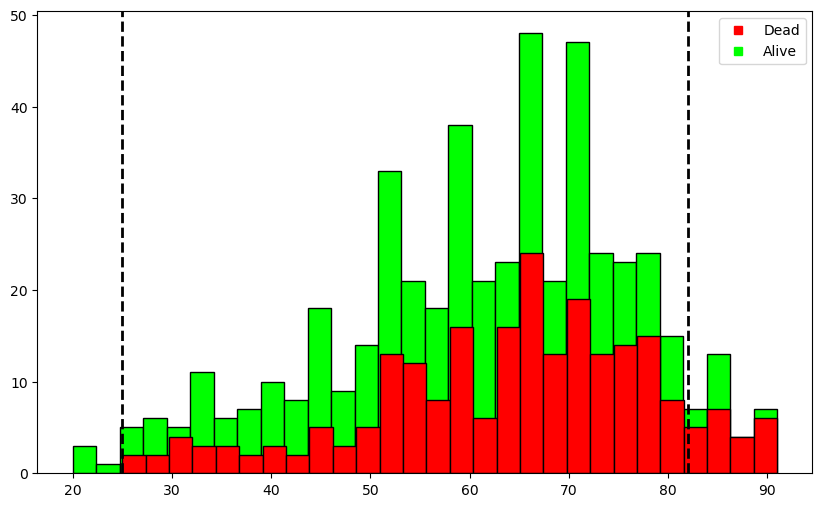

In [54]:
plt.hist(age, bins = 30, edgecolor = 'black', color = '#00FF00')
plt.hist(age[dead_ind], bins = 28, edgecolor = 'black', color = 'red')
plt.axvline(25, color='black', linestyle = 'dashed', linewidth = 2)
plt.axvline(82, color='black', linestyle = 'dashed', linewidth = 2)
legend_handles = [plt.Line2D([], [], color = 'red', label = 'Dead', marker='s', linestyle = 'None'),
                  plt.Line2D([], [], color = '#00FF00', label = 'Alive', marker='s', linestyle = 'None')
                 ]
plt.legend(handles = legend_handles, loc = "best")
plt.show()

In [55]:
low = 25
high = 82

In [56]:
a = np.unique(age[(age > high) | (age < low)])

In [57]:
data_clean = data_clean.drop(data_clean[data_clean['Age'].isin(a)].index)
df = df.drop(df[df['Age'].isin(a)].index)

df_grouped = data_clean.groupby('Patient_id')

In [58]:
len(np.unique(data_clean['Patient_id']))
# Remaining patients after the age screening

459

In [59]:
dead =[]

for i in data_clean['Patient_id'].unique() :
    dead.append(np.array(df_grouped.get_group(i)['Binary_outcome'])[0])

sum(np.array(dead))

214.0

## Removing patients - Range for days in ICU

The same for the staying days: patients with too many days in ICU can be noisy for our purposes and they could weight too much in our model (too much rows for a single patient could influence the result).

In [60]:
days = np.array(df_grouped.size())

In [61]:
dead = []

for i in data_clean['Patient_id'].unique() :
    dead.append(np.array(df_grouped.get_group(i)['Binary_outcome'])[0])

dead = np.array(dead)
dead_ind = np.where(dead == 1)

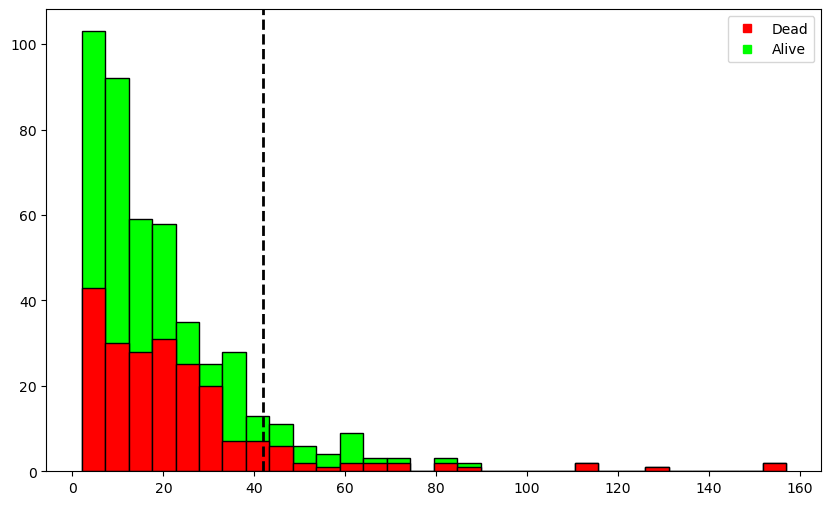

In [62]:
plt.hist(days, bins = 30, edgecolor = 'black', color = '#00FF00')
plt.hist(days[dead_ind], bins = 30, edgecolor = 'black', color = 'red')
plt.axvline(42, color='black', linestyle = 'dashed', linewidth = 2)
legend_handles = [plt.Line2D([], [], color = 'red', label = 'Dead', marker='s', linestyle = 'None'),
                  plt.Line2D([], [], color = '#00FF00', label = 'Alive', marker='s', linestyle = 'None')
                 ]
plt.legend(handles = legend_handles, loc = "best")
plt.show()

In [63]:
# Lower and upper limits of our selection
low = 0
high = 42

In [64]:
d = np.unique(days[(days > high) | (days < low)])
d

array([ 43,  44,  45,  46,  47,  48,  49,  50,  52,  53,  55,  56,  57,
        59,  60,  61,  62,  63,  65,  67,  68,  71,  72,  74,  80,  83,
        86,  88, 114, 126, 154, 157])

In [65]:
for i in data_clean['Patient_id'].unique() :
    total_size = df_grouped.size()[i]
    if total_size < low or total_size > high :
        data_clean = data_clean.drop(data_clean[data_clean['Patient_id'] == i].index)
        df = df.drop(df[df['Patient_id'] == i].index)

df_grouped = data_clean.groupby('Patient_id')

In [66]:
len(np.unique(data_clean['Patient_id']))

411

In [67]:
dead = []

for i in data_clean['Patient_id'].unique() :
    dead.append(np.array(df_grouped.get_group(i)['Binary_outcome'])[0])

sum(np.array(dead))

190.0

In [68]:
sum(np.array(data_clean['Binary_outcome'])),data_clean.shape[0]
# Balanced distribution of the binary outcome

(3243.0, 6530)

## Checking for "strange" values

We check for extremely out-of-range values (negative or too high values), keeping in mind that we are dealing with pathological patients, so it is possible not to see only physiological values.

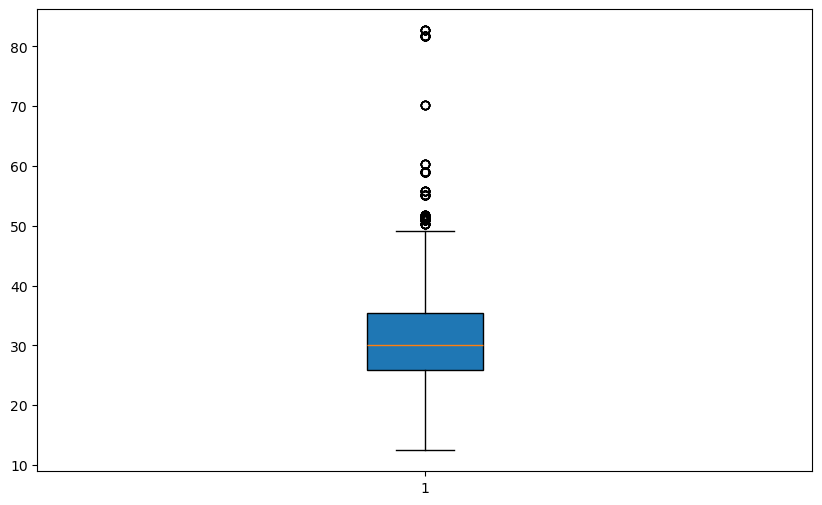

In [69]:
#Plot of the distribution of each variable
plt.boxplot(data_clean['BMI'].dropna(), vert = True, patch_artist = True)
plt.show()

In [70]:
bmi = []
dead = []

for i in data_clean['Patient_id'].unique() :
    bmi.append(np.array(df_grouped.get_group(i)['BMI'])[0])
    dead.append(np.array(df_grouped.get_group(i)['Binary_outcome'])[0])

bmi = np.array(bmi)
dead = np.array(dead)
dead_ind = np.where(dead == 1)

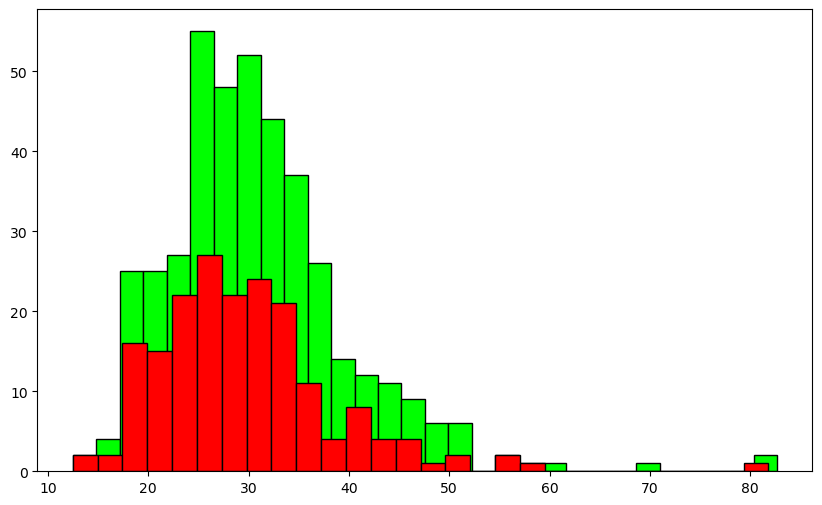

In [71]:
plt.hist(bmi, bins = 30, edgecolor = 'black', color = '#00FF00')
plt.hist(bmi[dead_ind], bins = 28, edgecolor = 'black', color = 'red')
plt.show()

In [72]:
# Substitution of BMI values higher than 70 with NAs
for i in range(data_clean.shape[0]) :
    if data_clean.iloc[i, data_clean.columns.get_loc('BMI')] > 70 :
        data_clean.iloc[i, data_clean.columns.get_loc('BMI')] = np.nan

In [73]:
df_grouped = data_clean.groupby('Patient_id')

In [74]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6530 entries, 0 to 12465
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient_id                  6530 non-null   float64
 1   ICU_Stay                    6530 non-null   float64
 2   ICU_Day                     6530 non-null   float64
 3   External_transfer_flag      6530 non-null   float64
 4   Admission_source_name       6530 non-null   object 
 5   Binary_outcome              6530 non-null   float64
 6   Global_cause_failure        3069 non-null   object 
 7   Patient_category            6530 non-null   object 
 8   COVID_status                6530 non-null   bool   
 9   Age                         6530 non-null   float64
 10  Ethnicity                   6530 non-null   object 
 11  Gender                      6530 non-null   object 
 12  Race                        6530 non-null   object 
 13  Smoking_status              6530 non-

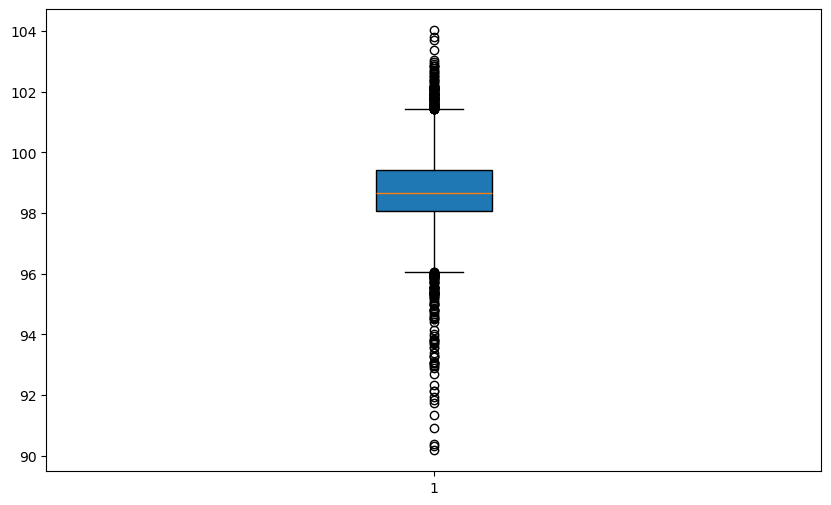

In [75]:
plt.boxplot(data_clean['Temperature'].dropna(), vert = True, patch_artist = True)
plt.show()

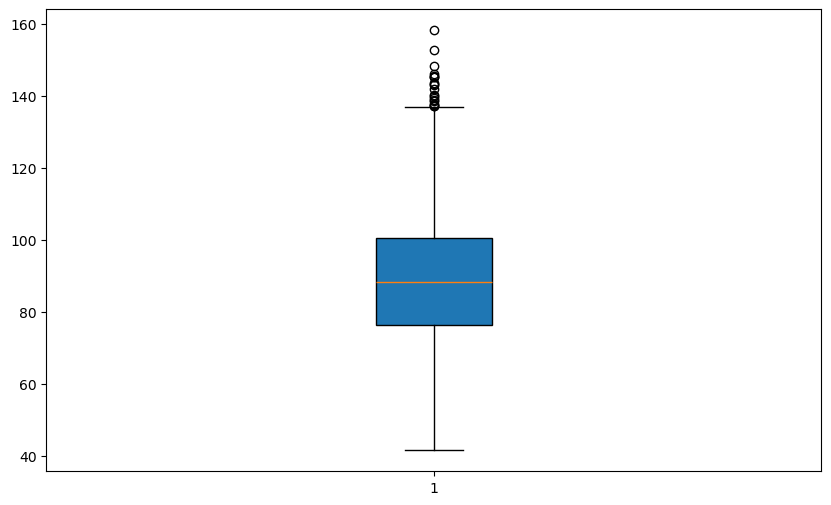

In [76]:
plt.boxplot(data_clean['Heart_rate'].dropna(), vert = True, patch_artist = True)
plt.show()

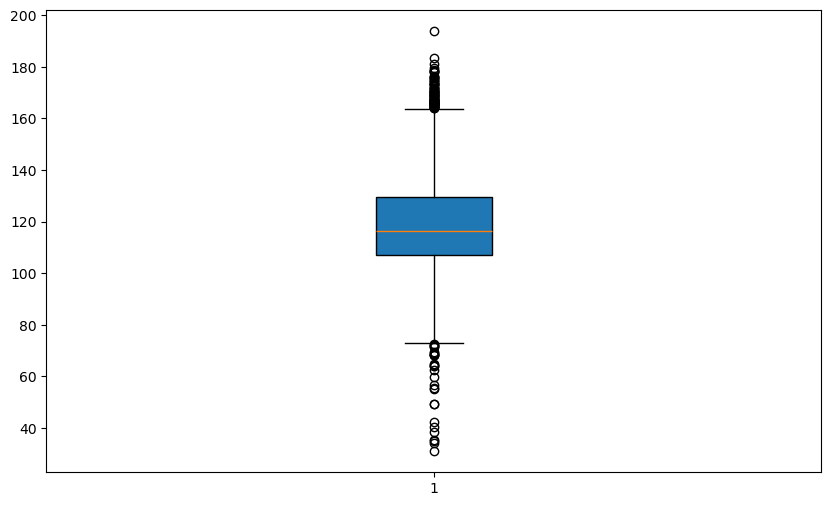

In [77]:
plt.boxplot(data_clean['Systolic_blood_pressure'].dropna(), vert = True, patch_artist = True)
plt.show()

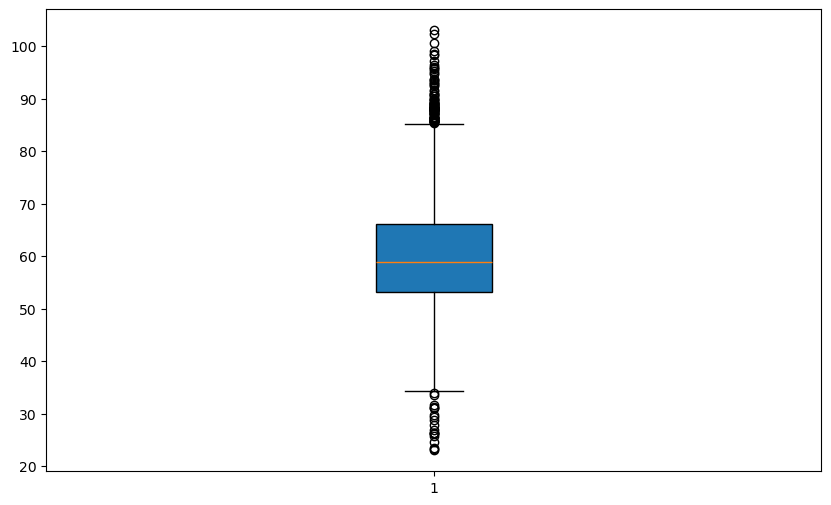

In [78]:
plt.boxplot(data_clean['Diastolic_blood_pressure'].dropna(), vert = True, patch_artist = True)
plt.show()

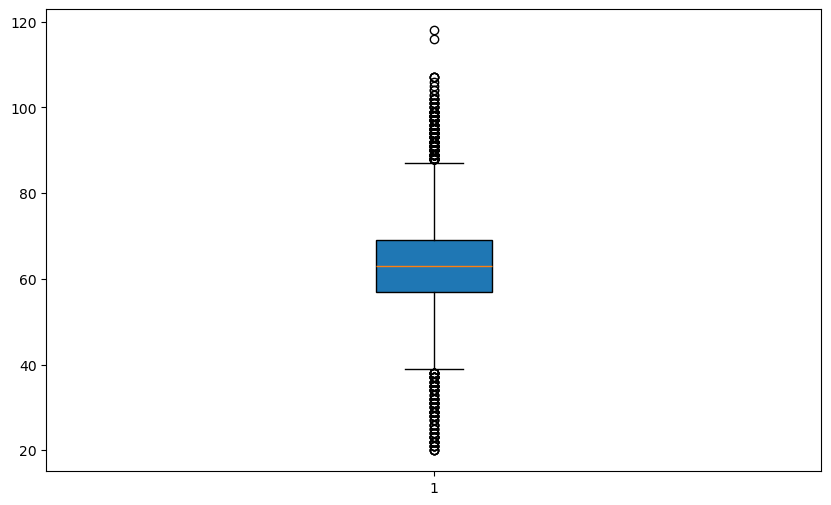

In [79]:
plt.boxplot(data_clean['Mean_arterial_pressure'].dropna(), vert = True, patch_artist = True)
plt.show()

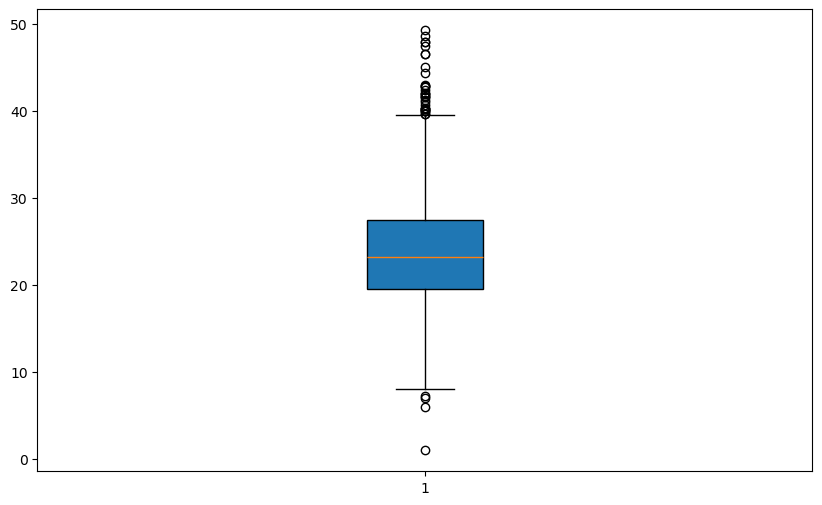

In [80]:
plt.boxplot(data_clean['Respiratory_rate'].dropna(), vert = True, patch_artist = True)
plt.show()

In [81]:
# Substitution of respiratoty rate values lower than 5 witn NAs
for i in range(data_clean.shape[0]) :
    if data_clean.iloc[i, data_clean.columns.get_loc('Respiratory_rate')] < 5 :
        data_clean.iloc[i, data_clean.columns.get_loc('Respiratory_rate')] = np.nan

In [82]:
df_grouped = data_clean.groupby('Patient_id')

In [83]:
data_clean[(data_clean['Cumulative_intubation_days'] > data_clean['Cumulative_ICU_days']) & (data_clean['Number_of_ICU_stays'] == 1)].iloc[:,10:30]

,Ethnicity,Gender,Race,Smoking_status,BMI,Admit_APS_score,Admit_SOFA_score,Cumulative_ICU_days,Number_of_ICU_stays,Tracheostomy_flag,Cumulative_intubation_days,SOFA_score,ECMO_flag,Intubation_flag,Hemodialysis_flag,CRRT_flag,Temperature,Heart_rate,Systolic_blood_pressure,Diastolic_blood_pressure
166,Not Hispanic or Latino,Male,Black or African American,Unknown Smoking Status,29.74,71.0,5.0,22.0,1.0,1.0,23.0,4.0,0.0,1.0,0.0,0.0,98.860000,80.458333,117.318182,55.318182
167,Not Hispanic or Latino,Male,Black or African American,Unknown Smoking Status,29.74,71.0,5.0,22.0,1.0,1.0,23.0,5.0,0.0,1.0,0.0,0.0,98.688889,90.333333,120.793103,58.000000
168,Not Hispanic or Latino,Male,Black or African American,Unknown Smoking Status,29.74,71.0,5.0,22.0,1.0,1.0,23.0,10.0,0.0,1.0,0.0,0.0,97.017647,85.714286,126.895833,56.979167
169,Not Hispanic or Latino,Male,Black or African American,Unknown Smoking Status,29.74,71.0,5.0,22.0,1.0,1.0,23.0,9.0,0.0,1.0,0.0,0.0,97.556522,59.480000,116.400000,46.520000
170,Not Hispanic or Latino,Male,Black or African American,Unknown Smoking Status,29.74,71.0,5.0,22.0,1.0,1.0,23.0,7.0,0.0,1.0,0.0,0.0,98.643478,61.833333,118.875000,43.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11404,Not Hispanic or Latino,Female,Black or African American,Past Smoker,44.58,62.0,3.0,20.0,1.0,1.0,26.0,8.0,0.0,1.0,0.0,0.0,98.700000,100.962963,112.333333,58.729167
11405,Not Hispanic or Latino,Female,Black or African American,Past Smoker,44.58,62.0,3.0,20.0,1.0,1.0,26.0,2.0,0.0,1.0,0.0,0.0,98.283333,103.083333,119.652174,63.652174
11406,Not Hispanic or Latino,Female,Black or African American,Past Smoker,44.58,62.0,3.0,20.0,1.0,1.0,26.0,2.0,0.0,1.0,0.0,0.0,98.633333,99.160000,130.583333,72.041667
11407,Not Hispanic or Latino,Female,Black or African American,Past Smoker,44.58,62.0,3.0,20.0,1.0,1.0,26.0,1.0,0.0,1.0,0.0,0.0,98.833333,95.269231,143.041667,82.625000


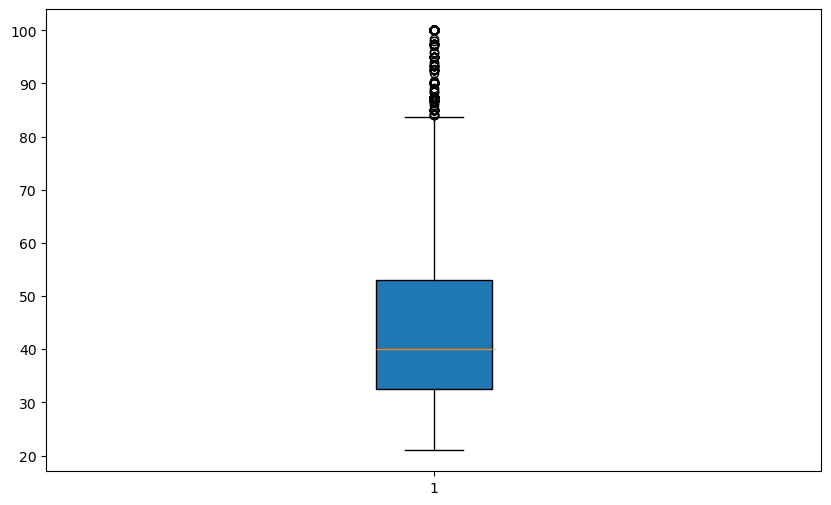

In [84]:
plt.boxplot(data_clean['FiO2'].dropna(), vert = True, patch_artist = True)
plt.show()

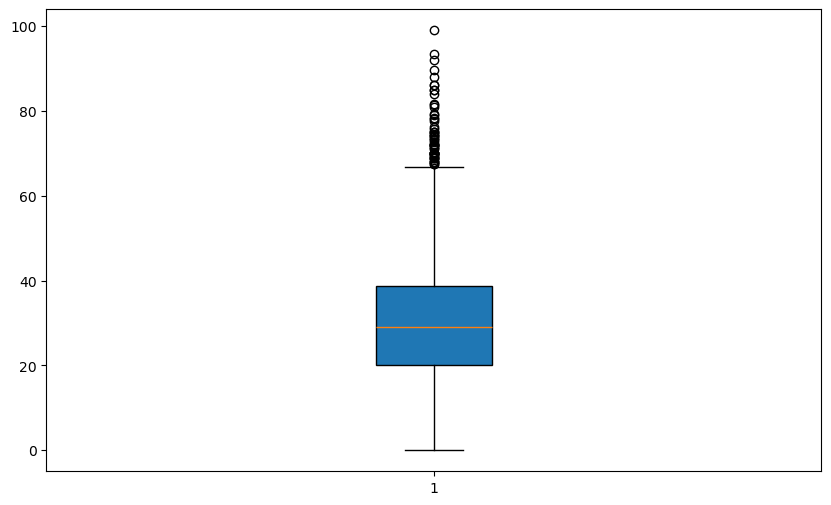

In [85]:
plt.boxplot(data_clean['Lung_Compliance'].dropna(), vert = True, patch_artist = True)
plt.show()

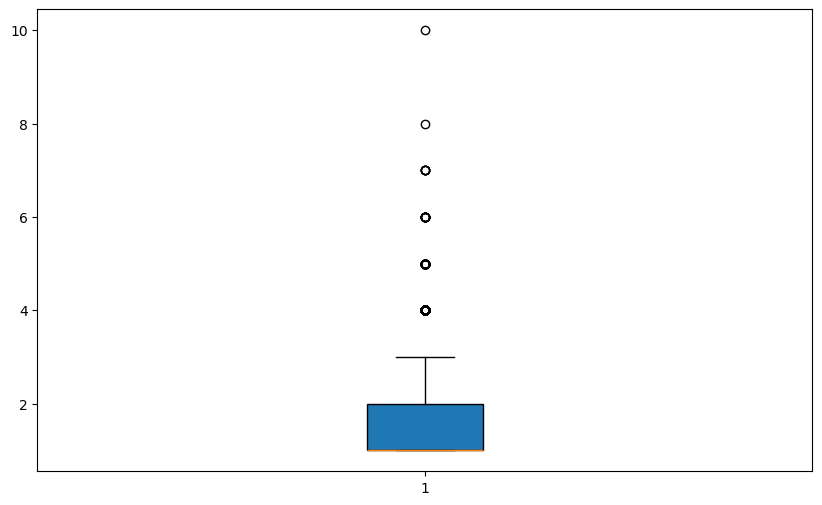

In [86]:
plt.boxplot(data_clean['PEEP_changes'].dropna(), vert = True, patch_artist = True)
plt.show()

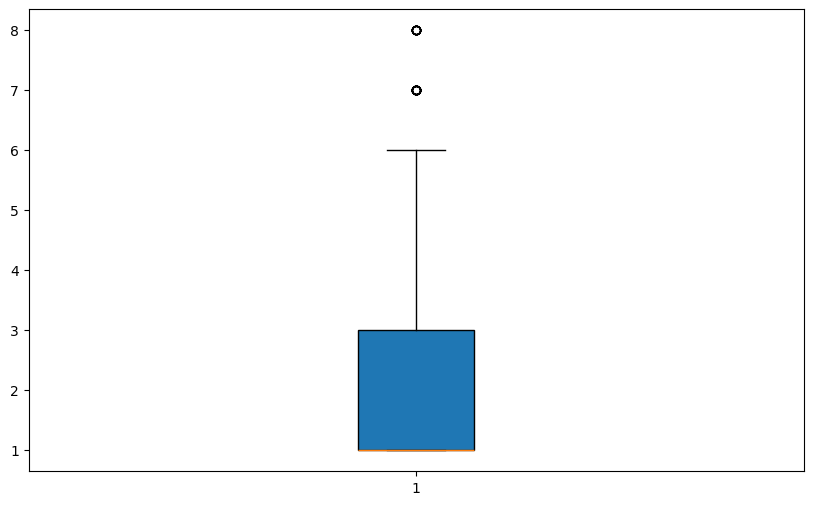

In [87]:
plt.boxplot(data_clean['Respiratory_rate_changes'].dropna(), vert = True, patch_artist = True)
plt.show()

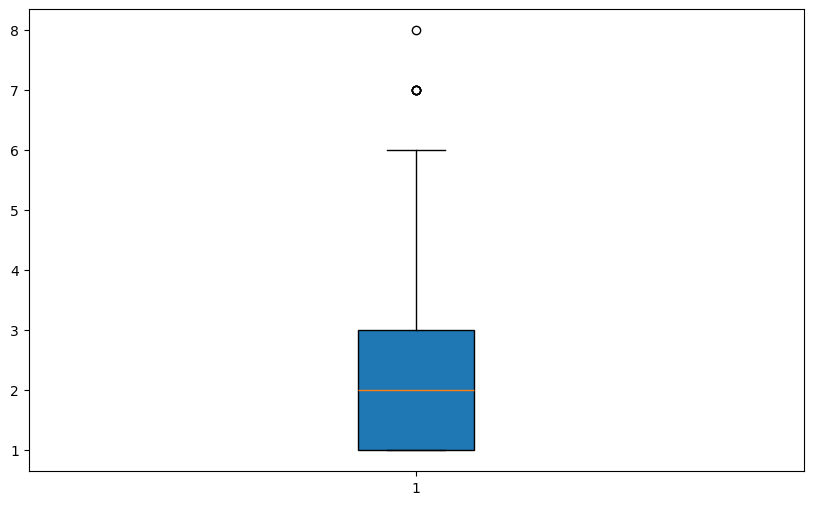

In [88]:
plt.boxplot(data_clean['FiO2_changes'].dropna(), vert = True, patch_artist = True)
plt.show()

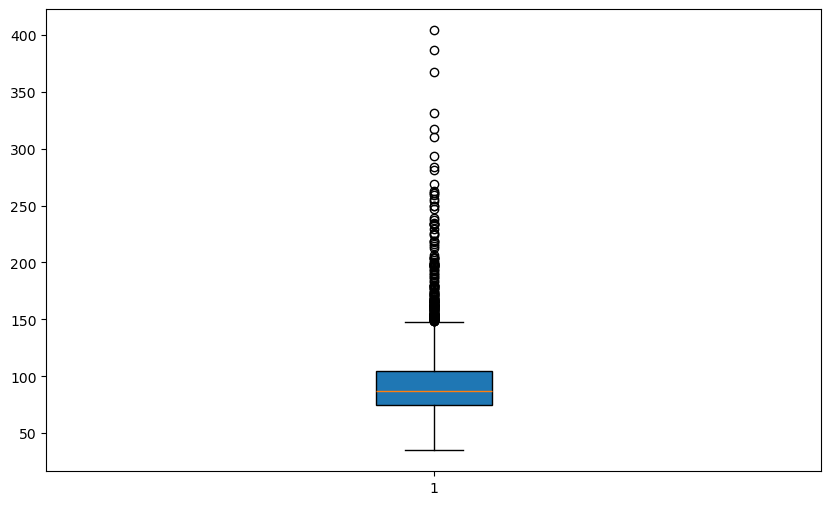

In [89]:
plt.boxplot(data_clean['ABG_PaO2'].dropna(), vert = True, patch_artist = True)
plt.show()

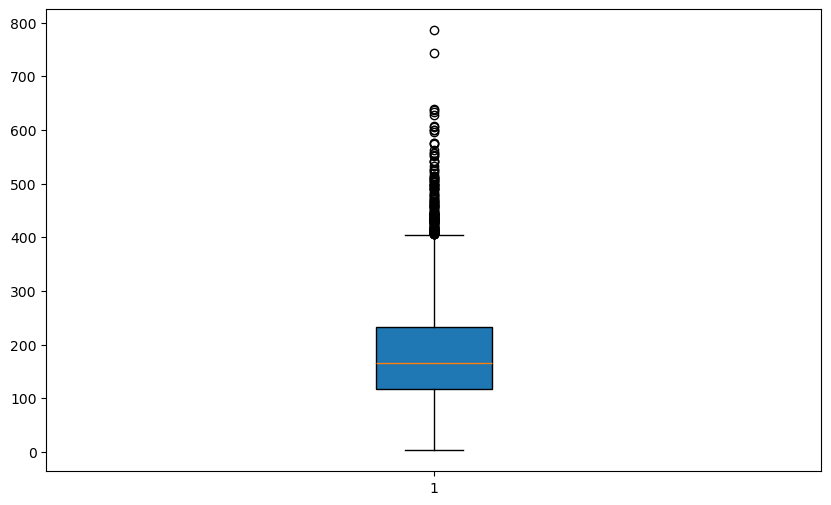

In [90]:
plt.boxplot(data_clean['PaO2FIO2_ratio'].dropna(), vert = True, patch_artist = True)
plt.show()

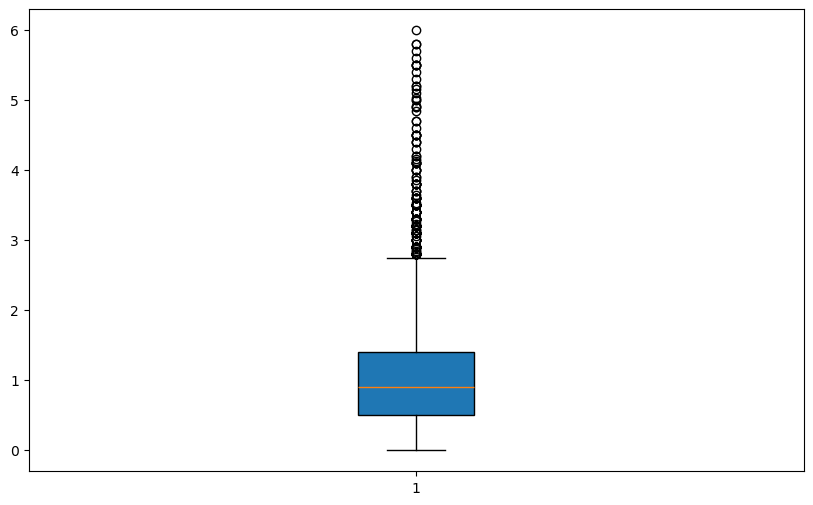

In [91]:
plt.boxplot(data_clean['Lymphocytes'].dropna(), vert = True, patch_artist = True)
plt.show()

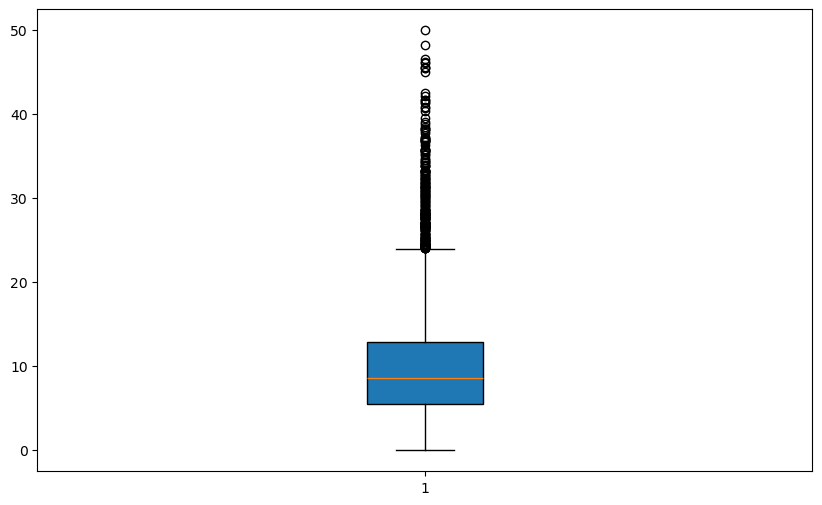

In [92]:
plt.boxplot(data_clean['Neutrophils'].dropna(), vert = True, patch_artist = True)
plt.show()

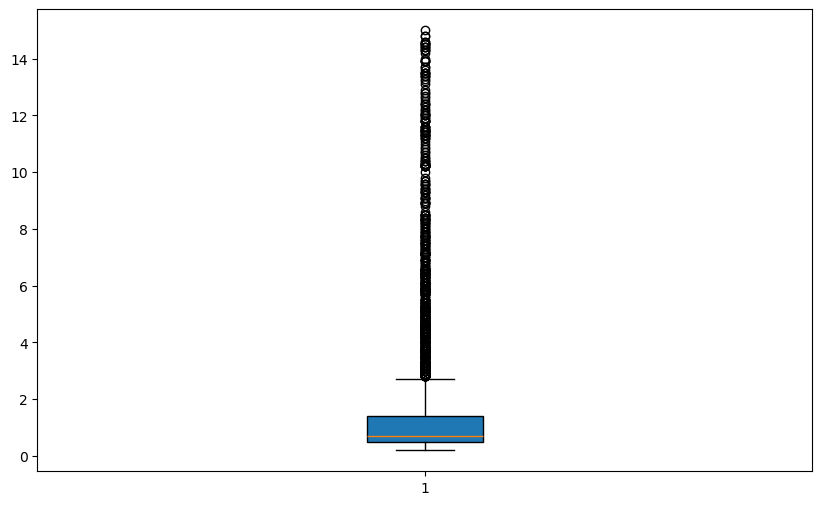

In [93]:
plt.boxplot(data_clean['Bilirubin'].dropna(), vert = True, patch_artist = True)
plt.show()

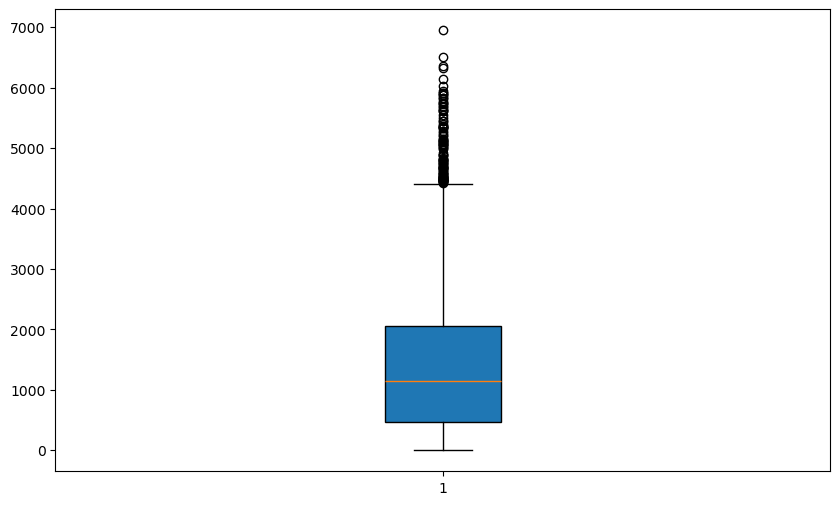

In [94]:
plt.boxplot(data_clean['Urine_output'].dropna(), vert = True, patch_artist = True)
plt.show()

In [95]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6530 entries, 0 to 12465
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient_id                  6530 non-null   float64
 1   ICU_Stay                    6530 non-null   float64
 2   ICU_Day                     6530 non-null   float64
 3   External_transfer_flag      6530 non-null   float64
 4   Admission_source_name       6530 non-null   object 
 5   Binary_outcome              6530 non-null   float64
 6   Global_cause_failure        3069 non-null   object 
 7   Patient_category            6530 non-null   object 
 8   COVID_status                6530 non-null   bool   
 9   Age                         6530 non-null   float64
 10  Ethnicity                   6530 non-null   object 
 11  Gender                      6530 non-null   object 
 12  Race                        6530 non-null   object 
 13  Smoking_status              6530 non-

In [96]:
df_grouped = data_clean.groupby('Patient_id')

## Categorical variables

We decide to manage the categorical variables introducing dummies (removing one column in order to have no problem with collinearity). The last three columns are transformed introducing some hypothesis on how these valeus are built and its meaning.

In [97]:
data_clean = data_clean.drop(columns = ['Episode_is_cured'])
# Looking at the dataset, this variable seems to be non-informative

In [98]:
data_clean_grouped = data_clean.groupby('Patient_id')

In [99]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6530 entries, 0 to 12465
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Patient_id                  6530 non-null   float64
 1   ICU_Stay                    6530 non-null   float64
 2   ICU_Day                     6530 non-null   float64
 3   External_transfer_flag      6530 non-null   float64
 4   Admission_source_name       6530 non-null   object 
 5   Binary_outcome              6530 non-null   float64
 6   Global_cause_failure        3069 non-null   object 
 7   Patient_category            6530 non-null   object 
 8   COVID_status                6530 non-null   bool   
 9   Age                         6530 non-null   float64
 10  Ethnicity                   6530 non-null   object 
 11  Gender                      6530 non-null   object 
 12  Race                        6530 non-null   object 
 13  Smoking_status              6530 non-

In [100]:
data = pd.DataFrame()

index_duration = data_clean.columns.get_loc('Episode_duration') # get the indexes
index_etiology = data_clean.columns.get_loc('Episode_etiology')
index_category = data_clean.columns.get_loc('Episode_category')

for i in data_clean['Patient_id'].unique() :
    d = data_clean_grouped.get_group(i)
    j = 0
    while j < d.shape[0] :
        if np.isnan(d.iloc[j,index_duration]) :  # going through the database until finding a non-null value
            j = j + 1
        else :
            n = int(d.iloc[j,index_duration])
            for k in range(j+1,j+n):
                if k < d.shape[0] :
                    d.iloc[k,index_category] = d.iloc[j,index_category] # propagation of the informaation
                    d.iloc[k,index_etiology] = d.iloc[j,index_etiology]
                    d.iloc[k,index_duration] = n
            j = j + n
    data = pd.concat([data,d], ignore_index = True)

In [101]:
data_grouped = data.groupby('Patient_id')

In [102]:
# Filling the cells above a viral diagnosis with the same etiology and category until the end of the patient stay or until another diagnosis
for i in range(1,data.shape[0]) :
    if data.iloc[i,0] == data.iloc[i-1,0] and data.iloc[i-1,index_etiology] == 'Viral' and pd.isna(data.iloc[i,index_etiology]) :
        data.iloc[i,index_etiology] = 'Viral'
        data.iloc[i,index_category] = data.iloc[i-1,index_category]

In [103]:
data_grouped = data.groupby('Patient_id')

In [104]:
data_grouped.get_group(43)

,Patient_id,ICU_Stay,ICU_Day,External_transfer_flag,Admission_source_name,Binary_outcome,Global_cause_failure,Patient_category,COVID_status,Age,...,Hemoglobin,Platelets,Bicarbonate,Creatinine,Albumin,Bilirubin,has_bal,Episode_category,Episode_etiology,Episode_duration
0,43.0,1.0,1.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,10.400000,165.0,23.000000,0.72,3.5,0.4,True,CAP,Viral,NaN
1,43.0,1.0,2.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,9.800000,199.0,24.000000,0.99,2.9,0.4,False,CAP,Viral,NaN
2,43.0,1.0,3.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,9.100000,247.0,26.000000,1.15,2.7,0.3,False,CAP,Viral,NaN
3,43.0,1.0,4.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,8.700000,258.0,26.000000,1.21,2.7,0.3,False,CAP,Viral,NaN
4,43.0,1.0,5.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,8.900000,257.0,27.000000,1.24,2.5,0.3,False,CAP,Viral,NaN
5,43.0,1.0,6.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,8.700000,286.0,28.000000,0.93,2.4,0.3,False,CAP,Viral,NaN
6,43.0,1.0,7.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,8.300000,330.0,29.000000,0.71,2.4,0.2,False,CAP,Viral,NaN
7,43.0,1.0,8.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,8.200000,368.0,30.000000,0.63,2.3,0.2,False,CAP,Viral,NaN
8,43.0,1.0,9.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,8.100000,359.0,31.000000,0.67,2.4,0.2,False,CAP,Viral,NaN
9,43.0,1.0,10.0,0.0,From Home/Work,0.0,NaN,COVID-19,True,72.0,...,7.800000,351.0,32.000000,0.68,2.3,0.2,True,CAP,Viral,NaN


In [105]:
data["Episode_duration"] = data["Episode_duration"].fillna(0)

In [106]:
# Setting un uknown etiology for Non-PNA-ctrl patients
for i in range(1,data.shape[0]) :
    if data.iloc[i,index_category] == 'Non-PNA-ctrl' :
        data.iloc[i,index_etiology] = 'Unknown (non-PNA)'

In [107]:
# Filling NAs cells
for i in range(1,data.shape[0]) :
    if data.iloc[i,0] == data.iloc[i-1,0] and data.iloc[i-1,index_category] == 'Non-PNA-ctrl' and pd.isna(data.iloc[i,index_category]) :
        data.iloc[i,index_category] = 'Non-PNA-ctrl'
        data.iloc[i,index_etiology] = 'Unknown (non-PNA)'

In [108]:
data["Episode_category"] = data["Episode_category"].fillna('No episode')
data["Episode_etiology"] = data["Episode_etiology"].fillna('No info')

In [109]:
data_grouped = data.groupby('Patient_id')

In [110]:
comments = []

comments_index = data.columns.get_loc('Global_cause_failure')

for i in range(data.shape[0]) :
    if pd.notna(data.iloc[i,comments_index]) :
        comments.append(data.iloc[i,comments_index].split(','))

comments = np.concatenate(comments).tolist()

# For this variable, we introduce a column for every different comment (1 if the comment is present, 0 otherwise). Some patients have no comments,
# but the variable seems to be informative, so we keep it.

In [111]:
new = pd.DataFrame(index = range(data.shape[0]), columns = np.unique(comments))

In [112]:
for i in range(data.shape[0]):
    if pd.notna(data.iloc[i,comments_index]) :
        lista = data.iloc[i,comments_index].split(',')
        for comm in lista :
            index = new.columns.get_loc(comm)
            new.iloc[i,index] = True

new = new.fillna(False)

In [113]:
data = data.join(new)
data = data.drop(columns = ['Global_cause_failure'])

In [114]:
data_dumm = pd.get_dummies(data, columns = ['Admission_source_name', 'Patient_category', 'Ethnicity', 'Gender',
                                     'Race', 'Smoking_status', 'Episode_category', 'Episode_etiology'], drop_first = True)

In [115]:
data_grouped = data.groupby('Patient_id')
data_dumm_grouped = data_dumm.groupby('Patient_id')

In [116]:
data_dumm['External_transfer_flag'] = list(map(bool, data_dumm['External_transfer_flag']))
data_dumm['Binary_outcome'] = list(map(bool, data_dumm['Binary_outcome']))
data_dumm['Tracheostomy_flag'] = list(map(bool, data_dumm['Tracheostomy_flag']))
data_dumm['ECMO_flag'] = list(map(bool, data_dumm['ECMO_flag']))
data_dumm['Intubation_flag'] = list(map(bool, data_dumm['Intubation_flag']))
data_dumm['Hemodialysis_flag'] = list(map(bool, data_dumm['Hemodialysis_flag']))
data_dumm['CRRT_flag'] = list(map(bool, data_dumm['CRRT_flag']))
data_dumm['Norepinephrine_flag'] = list(map(bool, data_dumm['Norepinephrine_flag']))

In [117]:
data_dumm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6530 entries, 0 to 6529
Data columns (total 94 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Patient_id                                                 6530 non-null   float64
 1   ICU_Stay                                                   6530 non-null   float64
 2   ICU_Day                                                    6530 non-null   float64
 3   External_transfer_flag                                     6530 non-null   bool   
 4   Binary_outcome                                             6530 non-null   bool   
 5   COVID_status                                               6530 non-null   bool   
 6   Age                                                        6530 non-null   float64
 7   BMI                                                        6478 non-null   float64
 8   Admit_AP

## Train and Test split (balanced)

The train/test split is done so that the ratio between some features is preserved. In particular, we want both the datasets to be equally distributed in terms of death, number of patients, number of staying days and number of different types of pathology.

In [118]:
y = data_dumm['Binary_outcome']
X = data_dumm.drop(columns = ['Binary_outcome', 'Patient_id'])
X_with_index = data_dumm.drop(columns = ['Binary_outcome'])

In [119]:
def split_with_constraints(X, y) :
    id = X['Patient_id'].unique()
    ok = False
    while(ok == False) :
        train_id = random.sample(sorted(id), k = round(len(id)*0.8))
        test_id = set(id) - set(train_id)
        index_train = X[X['Patient_id'].isin(train_id)].index
        index_test = X[X['Patient_id'].isin(test_id)].index
        ok = check(X, y, index_train, index_test)
        X_train =  X.iloc[index_train,:]
        X_test = X.iloc[index_test,:]
        y_train = y[index_train]
        y_test = y[index_test]
    return X_train.reset_index(drop = True), X_test.reset_index(drop = True), y_train.reset_index(drop = True), y_test.reset_index(drop = True)


def check(X, y, index_train, index_test) :
    ok = False
    if (0.7*X.shape[0] <= X.iloc[index_train,:].shape[0]) :  # Check of the dimension of the set
        if (X.iloc[index_train,:].shape[0] <= 0.8*X.shape[0]) :
            if (0.45*len(index_train) <= np.sum(y[index_train])) :  # Check of the distribution of the outcome
                if (np.sum(y[index_train]) <= 0.55*len(index_train)) :
                    if (0.45*len(index_test) <= np.sum(y[index_test])) :
                        if (np.sum(y[index_test]) <= 0.55*len(index_test)) :
                            unique_id_index_train = X.iloc[index_train,:].drop_duplicates(subset = ['Patient_id']).index
                            unique_id_index_test = X.iloc[index_test,:].drop_duplicates(subset = ['Patient_id']).index
                            if (0.45*len(unique_id_index_train) <= np.sum(y[unique_id_index_train])) :
                                if (np.sum(y[unique_id_index_train]) <= 0.55*len(unique_id_index_train)) :
                                    if (0.45*len(unique_id_index_test) <= np.sum(y[unique_id_index_test])) :
                                        if (np.sum(y[unique_id_index_test]) <= 0.55*len(unique_id_index_test)) :
                                            n_non_pn_train = np.sum(X.loc[unique_id_index_train,'Patient_category_Non-Pneumonia Control'])  # Check for category
                                            n_other_pn_train = np.sum(X.loc[unique_id_index_train,'Patient_category_Other Pneumonia'])
                                            n_other_viral_train = np.sum(X.loc[unique_id_index_train,'Patient_category_Other Viral Pneumonia'])
                                            n_covid_train = len(unique_id_index_train) - n_non_pn_train - n_other_pn_train - n_other_viral_train
                                            n_non_pn_test = np.sum(X.loc[unique_id_index_test,'Patient_category_Non-Pneumonia Control'])
                                            n_other_pn_test = np.sum(X.loc[unique_id_index_test,'Patient_category_Other Pneumonia'])
                                            n_other_viral_test = np.sum(X.loc[unique_id_index_test,'Patient_category_Other Viral Pneumonia'])
                                            n_covid_test = len(unique_id_index_test) - n_non_pn_test - n_other_pn_test - n_other_viral_test
                                            if (n_non_pn_train >= 3.5*n_non_pn_test) :   # Check of the ratio between categories
                                                if (n_non_pn_train <= 4.5*n_non_pn_test) :
                                                    if (n_other_pn_train >= 3.5*n_other_pn_test) :
                                                        if (n_other_pn_train <= 4.5*n_other_pn_test) :
                                                            if (n_other_viral_train >= 3.5*n_other_viral_test) :
                                                                if (n_other_viral_train <= 4.5*n_other_viral_test) :
                                                                    if (n_covid_train >= 3.5*n_covid_test) :
                                                                        if (n_covid_train <= 4.5*n_covid_test) :
                                                                            ok = True
    return ok

# Our function select some random patients (not single rows) and put them in the train set with all their history. Then we check if the split satisfies
# our condition: if yes, we have done; if no, repeat the split.

In [120]:
X_train, X_test, y_train, y_test = split_with_constraints(X_with_index, y)

In [121]:
X_test['Patient_id'].unique()

array([ 141.,  263.,  395.,  666.,  756.,  791.,  887.,  926.,  948.,
       1014., 1065., 1111., 1183., 1270., 1471., 1560., 1749., 1819.,
       2192., 2434., 2607., 2731., 2821., 2911., 3008., 3020., 3232.,
       3242., 3271., 3524., 3579., 3623., 3627., 4005., 4203., 4265.,
       4278., 4480., 4547., 4589., 4608., 4619., 4651., 4828., 4922.,
       5044., 5331., 5372., 5479., 5806., 6308., 6315., 6359., 6523.,
       6535., 7086., 7208., 7232., 7301., 7447., 7595., 7754., 7826.,
       7877., 7888., 8059., 8216., 8289., 8321., 8327., 8410., 8698.,
       8961., 9061., 9115., 9238., 9449., 9463., 9625., 9708., 9845.,
       9883.])

In [122]:
# Check for our conditions
print(X_train.shape, X_test.shape)

(5210, 93) (1320, 93)


In [123]:
print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))

0.4963531669865643 0.49772727272727274


In [124]:
print(np.sum(y_train[X_train.drop_duplicates(subset = ['Patient_id']).index])/len(y_train[X_train.drop_duplicates(subset = ['Patient_id']).index]),
      np.sum(y_test[X_test.drop_duplicates(subset = ['Patient_id']).index])/len(y_test[X_test.drop_duplicates(subset = ['Patient_id']).index]))

0.45592705167173253 0.4878048780487805


In [125]:
set(X_train['Patient_id']) - set(X_test['Patient_id']) == set(X_train['Patient_id'])

True

In [126]:
# Checking for number of patients belonging to the same category
print(X_train.loc[X_train.drop_duplicates(subset = ['Patient_id']).index,'Patient_category_Non-Pneumonia Control'].value_counts())

Patient_category_Non-Pneumonia Control
False    277
True      52
Name: count, dtype: int64


In [127]:
print(X_test.loc[X_test.drop_duplicates(subset = ['Patient_id']).index,'Patient_category_Non-Pneumonia Control'].value_counts())

Patient_category_Non-Pneumonia Control
False    70
True     12
Name: count, dtype: int64


In [128]:
print(X_train.loc[X_train.drop_duplicates(subset = ['Patient_id']).index,'Patient_category_Other Pneumonia'].value_counts())

Patient_category_Other Pneumonia
False    191
True     138
Name: count, dtype: int64


In [129]:
print(X_test.loc[X_test.drop_duplicates(subset = ['Patient_id']).index,'Patient_category_Other Pneumonia'].value_counts())

Patient_category_Other Pneumonia
False    47
True     35
Name: count, dtype: int64


In [130]:
print(X_train.loc[X_train.drop_duplicates(subset = ['Patient_id']).index,'Patient_category_Other Viral Pneumonia'].value_counts())

Patient_category_Other Viral Pneumonia
False    301
True      28
Name: count, dtype: int64


In [131]:
print(X_test.loc[X_test.drop_duplicates(subset = ['Patient_id']).index,'Patient_category_Other Viral Pneumonia'].value_counts())

Patient_category_Other Viral Pneumonia
False    75
True      7
Name: count, dtype: int64


## Imputing the NAs (numeric variables)

We choose the KNN-imputer in order to have no out-of-range values and we use four different imputer (one for every type of pathology). Note that the imputers are first fitted on the train set, then employed on both the sets : in this way, the patients of the test set do not influence the patients of the train.

In [132]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 93 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Patient_id                                                 5210 non-null   float64
 1   ICU_Stay                                                   5210 non-null   float64
 2   ICU_Day                                                    5210 non-null   float64
 3   External_transfer_flag                                     5210 non-null   bool   
 4   COVID_status                                               5210 non-null   bool   
 5   Age                                                        5210 non-null   float64
 6   BMI                                                        5173 non-null   float64
 7   Admit_APS_score                                            5210 non-null   float64
 8   Admit_SO

In [133]:
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns
numeric_features

Index(['Patient_id', 'ICU_Stay', 'ICU_Day', 'Age', 'BMI', 'Admit_APS_score',
       'Admit_SOFA_score', 'Cumulative_ICU_days', 'Number_of_ICU_stays',
       'Cumulative_intubation_days', 'SOFA_score', 'Temperature', 'Heart_rate',
       'Systolic_blood_pressure', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'Norepinephrine_rate', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_motor_response', 'GCS_verbal_response', 'RASS_score', 'PEEP',
       'FiO2', 'Plateau_Pressure', 'Lung_Compliance', 'PEEP_changes',
       'Respiratory_rate_changes', 'FiO2_changes', 'ABG_pH', 'ABG_PaCO2',
       'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count', 'Lymphocytes', 'Neutrophils',
       'Hemoglobin', 'Platelets', 'Bicarbonate', 'Creatinine', 'Albumin',
       'Bilirubin', 'Episode_duration'],
      dtype='object')

In [134]:
imputer1 = KNNImputer(n_neighbors = 25, weights = 'distance')
imputer2 = KNNImputer(n_neighbors = 25, weights = 'distance')
imputer3 = KNNImputer(n_neighbors = 25, weights = 'distance')
imputer4 = KNNImputer(n_neighbors = 25, weights = 'distance')

In [135]:
viral_index_train = X_train[X_train['Patient_category_Other Viral Pneumonia'] == True].index
nonpn_index_train = X_train[X_train['Patient_category_Non-Pneumonia Control'] == True].index
otherpn_index_train = X_train[X_train['Patient_category_Other Pneumonia'] == True].index
covid_index_train = X_train[(X_train['Patient_category_Other Pneumonia'] == False) & (X_train['Patient_category_Non-Pneumonia Control'] == False) & (X_train['Patient_category_Other Viral Pneumonia'] == False)].index

viral_index_test = X_test[X_test['Patient_category_Other Viral Pneumonia'] == True].index
nonpn_index_test = X_test[X_test['Patient_category_Non-Pneumonia Control'] == True].index
otherpn_index_test = X_test[X_test['Patient_category_Other Pneumonia'] == True].index
covid_index_test = X_test[(X_test['Patient_category_Other Pneumonia'] == False) & (X_test['Patient_category_Non-Pneumonia Control'] == False) & (X_test['Patient_category_Other Viral Pneumonia'] == False)].index

In [136]:
imp_viral = imputer1.fit(X_train.loc[viral_index_train,numeric_features])
imp_nonpn = imputer2.fit(X_train.loc[nonpn_index_train,numeric_features])
imp_otherpn = imputer3.fit(X_train.loc[otherpn_index_train,numeric_features])
imp_covid = imputer4.fit(X_train.loc[covid_index_train,numeric_features])

In [137]:
X_train.loc[viral_index_train, numeric_features] = imputer1.transform(X_train.loc[viral_index_train, numeric_features])
X_train.loc[nonpn_index_train, numeric_features] = imputer2.transform(X_train.loc[nonpn_index_train, numeric_features])
X_train.loc[otherpn_index_train, numeric_features] = imputer3.transform(X_train.loc[otherpn_index_train, numeric_features])
X_train.loc[covid_index_train, numeric_features] = imputer4.transform(X_train.loc[covid_index_train, numeric_features])

In [138]:
X_test.loc[viral_index_test, numeric_features] = imputer1.transform(X_test.loc[viral_index_test, numeric_features])
X_test.loc[nonpn_index_test, numeric_features] = imputer2.transform(X_test.loc[nonpn_index_test, numeric_features])
X_test.loc[otherpn_index_test, numeric_features] = imputer3.transform(X_test.loc[otherpn_index_test, numeric_features])
X_test.loc[covid_index_test, numeric_features] = imputer4.transform(X_test.loc[covid_index_test, numeric_features])

In [139]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 93 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Patient_id                                                 5210 non-null   float64
 1   ICU_Stay                                                   5210 non-null   float64
 2   ICU_Day                                                    5210 non-null   float64
 3   External_transfer_flag                                     5210 non-null   bool   
 4   COVID_status                                               5210 non-null   bool   
 5   Age                                                        5210 non-null   float64
 6   BMI                                                        5210 non-null   float64
 7   Admit_APS_score                                            5210 non-null   float64
 8   Admit_SO

In [140]:
# Some variables are supposed to be integers, so we round the values to the nearest integer value
to_round = ['GCS_eye_opening', 'GCS_motor_response', 'GCS_verbal_response', 'PEEP_changes', 'Respiratory_rate_changes', 'FiO2_changes']
ind_col = [X_train.columns.get_loc(col) for col in to_round]
ind_col

[28, 29, 30, 36, 37, 38]

In [141]:
X_train.iloc[:,ind_col] = round(X_train.iloc[:,ind_col])
X_test.iloc[:,ind_col] = round(X_test.iloc[:,ind_col])

In [142]:
def point_five(n):
    return round(n * 2) / 2

# This function rounds the number to the nearest value with decimal part 0 or 0.5. We use it for 'RASS_score' values.
# Ex : 1.6 --> 1.5, 2.4 --> 2.5, 1.2 --> 1

In [143]:
X_train.iloc[:,X_train.columns.get_loc('RASS_score')] = point_five(X_train.iloc[:,X_train.columns.get_loc('RASS_score')])
X_test.iloc[:,X_test.columns.get_loc('RASS_score')] = point_five(X_test.iloc[:,X_test.columns.get_loc('RASS_score')])

In [144]:
id = X_train['Patient_id'].unique()
for i in id :
    X_train.loc[X_train['Patient_id'] == i, 'BMI'] = np.full(len(X_train.loc[X_train['Patient_id'] == i, 'BMI']), np.mean(X_train.loc[X_train['Patient_id'] == i, 'BMI']))

In [145]:
id = X_test['Patient_id'].unique()
for i in id :
    X_test.loc[X_test['Patient_id'] == i, 'BMI'] = np.full(len(X_test.loc[X_test['Patient_id'] == i, 'BMI']), np.mean(X_test.loc[X_test['Patient_id'] == i, 'BMI']))

## Variable correlation

In [146]:
# Compute the correlation matrix of the numerical variables
correlation_matrix = data_dumm.select_dtypes(include = ['int', 'float']).corr()

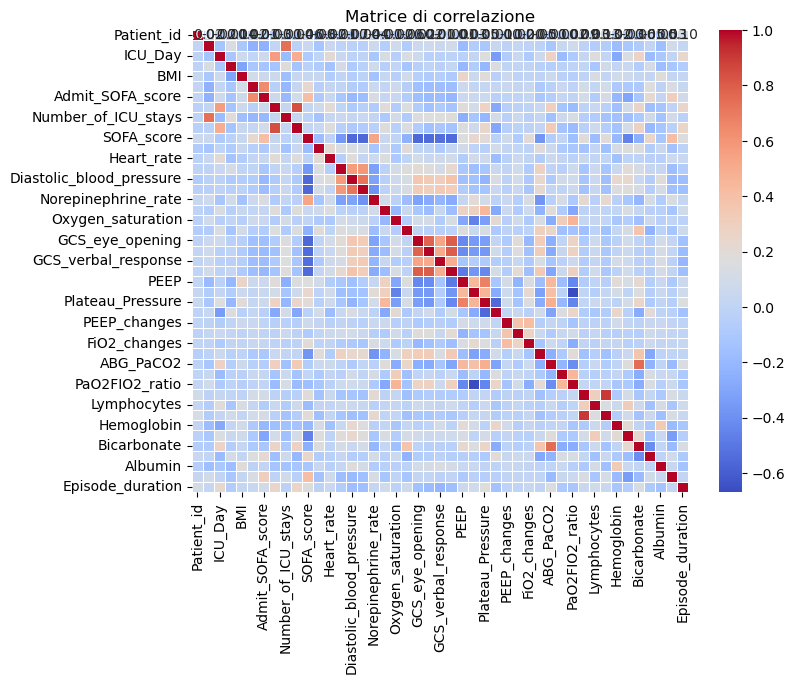

In [147]:
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice di correlazione')
plt.show()

In [148]:
high_correlation_pairs = (correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]).dropna(how = 'all')
high_correlation_pairs

,Patient_id,ICU_Stay,ICU_Day,Age,BMI,Admit_APS_score,Admit_SOFA_score,Cumulative_ICU_days,Number_of_ICU_stays,Cumulative_intubation_days,...,WBC_count,Lymphocytes,Neutrophils,Hemoglobin,Platelets,Bicarbonate,Creatinine,Albumin,Bilirubin,Episode_duration
Patient_id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ICU_Stay,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.737732,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ICU_Day,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.568983,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMI,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Admit_APS_score,NaN,NaN,NaN,NaN,NaN,1.000000,0.638324,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Admit_SOFA_score,NaN,NaN,NaN,NaN,NaN,0.638324,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cumulative_ICU_days,NaN,NaN,0.568983,NaN,NaN,NaN,NaN,1.000000,NaN,0.846458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_ICU_stays,NaN,0.737732,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cumulative_intubation_days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.846458,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
# Visualize the pairs with high correlation ( > 0.5 )
for i in range(high_correlation_pairs.shape[0]) :
    for j in range(i+1,high_correlation_pairs.shape[1]) :
        if pd.notna(high_correlation_pairs.iloc[i,j]) :
            print(high_correlation_pairs.columns[j],"vs", high_correlation_pairs.index[i], "correlation =", high_correlation_pairs.iloc[i,j], "\n")

Number_of_ICU_stays vs ICU_Stay correlation = 0.7377320592374078 

Cumulative_ICU_days vs ICU_Day correlation = 0.5689832815720185 

Admit_SOFA_score vs Admit_APS_score correlation = 0.6383239637099833 

Cumulative_intubation_days vs Cumulative_ICU_days correlation = 0.8464584576720839 

Diastolic_blood_pressure vs SOFA_score correlation = -0.5569191008429891 

Mean_arterial_pressure vs SOFA_score correlation = -0.5603077904903924 

Norepinephrine_rate vs SOFA_score correlation = 0.5352832369090027 

GCS_eye_opening vs SOFA_score correlation = -0.5624921822283756 

GCS_motor_response vs SOFA_score correlation = -0.5487344422228154 

GCS_verbal_response vs SOFA_score correlation = -0.5365561034264184 

RASS_score vs SOFA_score correlation = -0.5486094974162936 

Diastolic_blood_pressure vs Systolic_blood_pressure correlation = 0.5742431085270158 

Mean_arterial_pressure vs Systolic_blood_pressure correlation = 0.5829922333748355 

Mean_arterial_pressure vs Diastolic_blood_pressure corre

## Variable selection - Total mrmr

In [150]:
# Minimum Redundancy - Maximum Relevance to rank the features
selected_features_mrmr = mrmr_classif(X_train.drop(columns = ['Patient_id']), y_train, K = 40)

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 40.66it/s]


In [151]:
# Visualize the first 40 of the ranking
selected_features_mrmr

['Persistent inflammation only',
 'Antibiotics for other indication',
 'SOFA_score',
 'Age',
 'Platelets',
 'Diastolic_blood_pressure',
 'Superinfection pneumonia',
 'GCS_motor_response',
 'Temperature',
 'Lung_Compliance',
 'Mean_arterial_pressure',
 'RASS_score',
 'Lymphocytes',
 'CRRT_flag',
 'Race_Black or African American',
 'Bilirubin',
 'Hemoglobin',
 'Persistence',
 'Norepinephrine_rate',
 'ECMO_flag',
 'GCS_eye_opening',
 'Admission_source_name_From Home/Work',
 'Systolic_blood_pressure',
 'ICU_Stay',
 'FiO2',
 'Ethnicity_Unknown or Not Reported',
 'External_transfer_flag',
 'ABG_pH',
 'Number_of_ICU_stays',
 'Norepinephrine_flag',
 'Recurrence',
 'Plateau_Pressure',
 'Admission_source_name_Transfer from Acute Hospital',
 'Urine_output',
 'WBC_count',
 'Episode_duration',
 'Admission_source_name_From Community',
 'Smoking_status_Never Smoker',
 'Admission_source_name_Emergency Room',
 'BMI']

## Variable selection - Lasso

In [152]:
# Divide the numerical features and the categorical ones
numeric_features = X_train.drop(columns = ['Patient_id']).select_dtypes(include=['int', 'float']).columns
categorical_features = X_train.drop(columns = ['Patient_id']).select_dtypes(include=['bool', 'object']).columns

In [153]:
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features), # to standardize the numerical features
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', LogisticRegression(penalty = 'l1', solver = 'saga',random_state=2024)) # apply the logistic regression con l1 penalization and saga solver
])

In [154]:
# Define the grid for the C parameter
param_grid = {
    'clf__C': [0.001, 0.01, 0.025, 0.05, 0.75, 0.1, 1, 10]
}

In [155]:
# In the cross-validation splits, we want to keep together the observations of the same patients
groups = X_train['Patient_id']
group_kfold = GroupKFold(n_splits = 5)

In [156]:
grid_search = GridSearchCV(pipeline, param_grid, cv = group_kfold, scoring = 'roc_auc')
grid_search.fit(X_train.drop(columns = ['Patient_id']), y_train, groups = groups)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         Index(['ICU_Stay', 'ICU_Day', 'Age', 'BMI', 'Admit_APS_score',
       'Admit_SOFA_score', 'Cumulative_ICU_days', 'Number_of_ICU_stays',
       'Cumulative_intubation_days', 'SOFA_score', 'Temperature', 'Heart_rate',
       'Systolic_blood_pre...
       'Episode_category_VAP', 'Episode_etiology_Bacterial/viral',
       'Episode_etiology_Culture-negative', 'Episode_etiology_Indeterminate',
       'Episode_etiology_No info', 'Episode_etiology_Unknown (non-PNA)',
       'Episode_etiology_Viral'],
      dtype='object'))])),
                                       ('clf',
                                        LogisticRegression(penalty='l1',
                                                           random_state=2024,
                                                           solver='saga'))]),
             param_grid={'clf__C': [0.001, 0.01, 0.025, 0.05, 0.75, 0.1, 1,
                                    10]},
             scoring='roc_auc')

In [157]:
best_C = grid_search.best_params_['clf__C']
best_C

0.1

In [158]:
final_model = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', LogisticRegression(penalty = 'l1', solver = 'saga',random_state=2024,C = best_C))
])

final_model.fit(X_train.drop(columns = ['Patient_id']), y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['ICU_Stay', 'ICU_Day', 'Age', 'BMI', 'Admit_APS_score',
       'Admit_SOFA_score', 'Cumulative_ICU_days', 'Number_of_ICU_stays',
       'Cumulative_intubation_days', 'SOFA_score', 'Temperature', 'Heart_rate',
       'Systolic_blood_pressure', 'Diastolic_blood_pressure',
       'Mean_arterial_...
       'Episode_category_No episode', 'Episode_category_Non-PNA-ctrl',
       'Episode_category_VAP', 'Episode_etiology_Bacterial/viral',
       'Episode_etiology_Culture-negative', 'Episode_etiology_Indeterminate',
       'Episode_etiology_No info', 'Episode_etiology_Unknown (non-PNA)',
       'Episode_etiology_Viral'],
      dtype='object'))])),
                ('clf',
                 LogisticRegression(C=0.1, penalty='l1', random_state=2024,
                                    solver='saga'))])

In [159]:
coefficients = final_model.named_steps['clf'].coef_

In [160]:
selected_features_indices = [i for i, coef in enumerate(coefficients[0]) if coef != 0]

In [161]:
selected_features_lasso = X_train.drop(columns = ['Patient_id']).columns[selected_features_indices]
selected_features_lasso
# According to Lasso procedure, this are the variables with non-zero coefficients

Index(['ICU_Stay', 'ICU_Day', 'External_transfer_flag', 'COVID_status', 'Age',
       'Admit_APS_score', 'Admit_SOFA_score', 'Cumulative_ICU_days',
       'Number_of_ICU_stays', 'Tracheostomy_flag',
       'Cumulative_intubation_days', 'SOFA_score', 'ECMO_flag',
       'Intubation_flag', 'Hemodialysis_flag', 'CRRT_flag', 'Temperature',
       'Heart_rate', 'Systolic_blood_pressure', 'Diastolic_blood_pressure',
       'Norepinephrine_rate', 'Norepinephrine_flag', 'Respiratory_rate',
       'Oxygen_saturation', 'Urine_output', 'GCS_eye_opening',
       'GCS_verbal_response', 'RASS_score', 'PEEP', 'FiO2', 'Plateau_Pressure',
       'Lung_Compliance', 'PEEP_changes', 'Respiratory_rate_changes',
       'FiO2_changes', 'ABG_pH', 'ABG_PaO2', 'PaO2FIO2_ratio', 'WBC_count',
       'Bicarbonate', 'Creatinine', 'Episode_duration',
       'Antibiotics for other indication', 'Persistence',
       'Persistent inflammation only', 'Recurrence',
       'Superinfection pneumonia', 'Admission_source_name

## Variable selection - Permutational importance

In [162]:
rnd_clf = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 3, oob_score = True, random_state = 2024, max_features = 0.5)
rnd_clf.fit(X_train.drop(columns = ['Patient_id']), y_train)

RandomForestClassifier(max_features=0.5, min_samples_leaf=3, n_estimators=300,
                       oob_score=True, random_state=2024)

<Axes: >

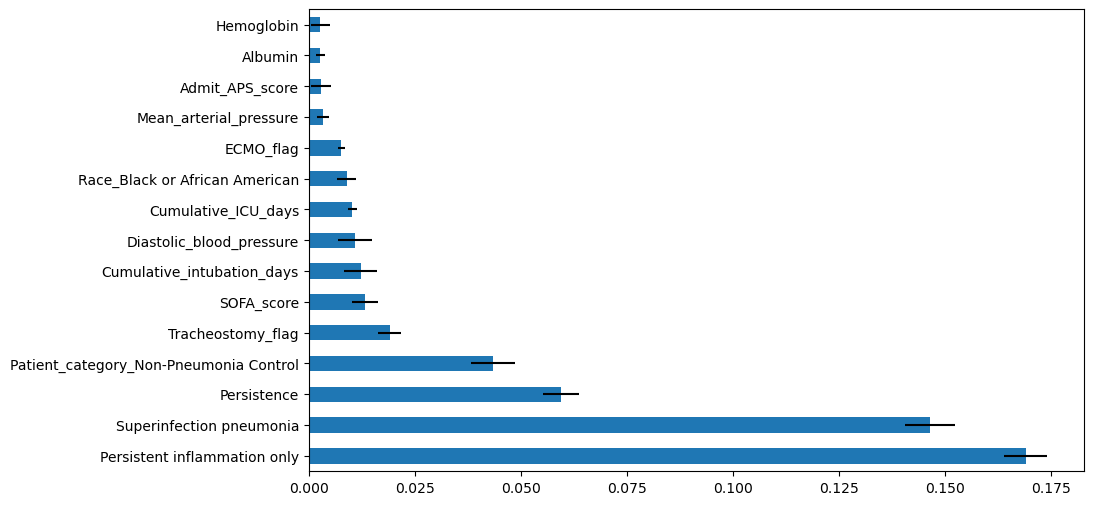

In [163]:
result = permutation_importance(rnd_clf, X_test.drop(columns = ['Patient_id']), y_test, n_repeats = 5, random_state = 2024)
sorted_idx = result.importances_mean.argsort()
f_importances = pd.Series(result.importances_mean[sorted_idx[::-1][0:15]], index = X_test.drop(columns = ['Patient_id']).columns[sorted_idx[::-1][0:15]])
f_importances.plot.barh(xerr = result.importances_std[sorted_idx[::-1][0:15]])
# We plot the first 15 variables, ordered by their permutational importance

In [164]:
selected_features_permutational = X_test.drop(columns = ['Patient_id']).columns[sorted_idx[::-1][0:40]]
# We select the first 40 variables

## Variable selection - Combining all the methods

After the variable selection using three different methods, we decide to select the variables selected by at least two methods.

In [165]:
selected = list(set(selected_features_mrmr) & set(selected_features_permutational) | set(selected_features_permutational) & set(selected_features_lasso) | set(selected_features_lasso) & set(selected_features_mrmr))

In [166]:
len(selected)

43

In [167]:
selected
# The models will be fitted with these variables

['Admission_source_name_Transfer from Acute Hospital',
 'Number_of_ICU_stays',
 'Episode_duration',
 'Ethnicity_Unknown or Not Reported',
 'Diastolic_blood_pressure',
 'Mean_arterial_pressure',
 'Episode_etiology_Culture-negative',
 'Norepinephrine_flag',
 'GCS_eye_opening',
 'Lung_Compliance',
 'CRRT_flag',
 'Patient_category_Other Pneumonia',
 'Plateau_Pressure',
 'ECMO_flag',
 'WBC_count',
 'Temperature',
 'PEEP',
 'Urine_output',
 'Hemoglobin',
 'Admission_source_name_From Home/Work',
 'Norepinephrine_rate',
 'Recurrence',
 'RASS_score',
 'Cumulative_ICU_days',
 'SOFA_score',
 'External_transfer_flag',
 'Persistent inflammation only',
 'Cumulative_intubation_days',
 'Persistence',
 'Superinfection pneumonia',
 'Patient_category_Non-Pneumonia Control',
 'ICU_Stay',
 'COVID_status',
 'Respiratory_rate',
 'Systolic_blood_pressure',
 'Age',
 'ABG_pH',
 'Antibiotics for other indication',
 'Admit_APS_score',
 'Race_Black or African American',
 'FiO2',
 'Tracheostomy_flag',
 'Smoking_sta

## Models - Random Forest

In [168]:
random_forest = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 3, oob_score = True, random_state = 2024, max_features = 0.5)
random_forest.fit(X_train[selected], y_train)

RandomForestClassifier(max_features=0.5, min_samples_leaf=3, n_estimators=500,
                       oob_score=True, random_state=2024)

In [169]:
y_pred = random_forest.predict(X_test[selected])

In [170]:
accuracy_score(y_pred, y_test)

0.8833333333333333

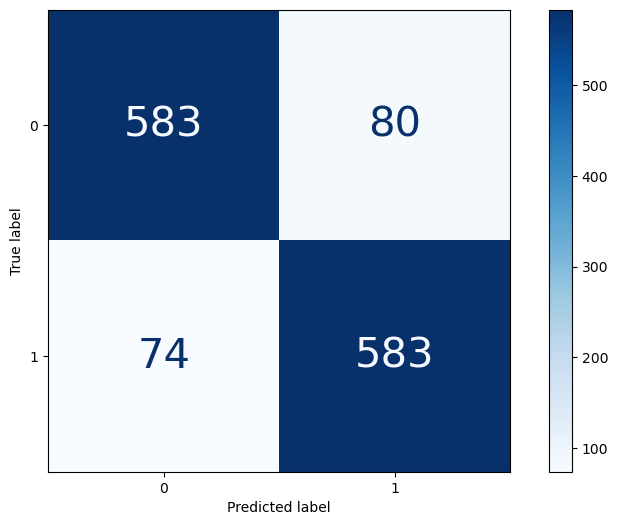

In [171]:
# The confusion matrix of the Random Forest 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues', text_kw = {'fontsize' : 30})
plt.show()

In [172]:
prob_pred = random_forest.predict_proba(X_test[selected])[:,1]

In [173]:
print(pd.DataFrame({'Vettore 1': y_test, 'Vettore 2': prob_pred}))

      Vettore 1  Vettore 2
0          True   0.306530
1          True   0.398363
2          True   0.356158
3          True   0.327983
4          True   0.294297
...         ...        ...
1315      False   0.165802
1316      False   0.038949
1317      False   0.015883
1318      False   0.000000
1319      False   0.000000

[1320 rows x 2 columns]


In [174]:
def error_with_prob(prob_pred, y_test, X_test) :
    y_test = np.array(y_test)
    prob_pred = np.array(prob_pred)
    id = X_test['Patient_id'].unique()
    grouped = X_test.groupby('Patient_id')
    err = 0
    for i in id :
        indexes = grouped.get_group(i).index
        err = err + np.sum(((y_test[indexes] - prob_pred[indexes])**2)/len(indexes))
    return err/len(id)

In [175]:
error_with_prob(prob_pred, y_test, X_test)
# This metric computes the MSE between the true label and the predicted probability, then the sum is returned

0.10930917526992133

In [176]:
y_test_single_outcome = y_test[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]
y_pred_single_outcome = y_pred[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]

In [177]:
accuracy_score(y_pred_single_outcome, y_test_single_outcome)
# This is the accuracy taking the true label and the preticted label in the last day for every patient (more informative than the raw accuracy)

0.9024390243902439

In [178]:
fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)

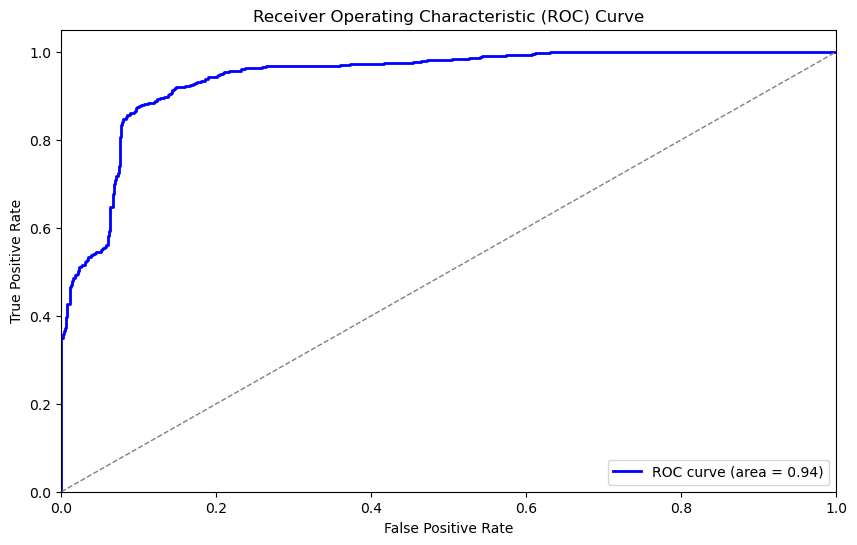

In [179]:
# Plot of the ROC curve
plt.plot(fpr, tpr, color = 'blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'gray', lw=1, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [180]:
def print_all_probability_function(X_test, prob_pred, y_test, save = False):
    id = X_test['Patient_id'].unique()
    for i in id :
        ind = X_test[X_test['Patient_id'] == i].index
        col = 'red' if np.sum(y_test[ind]) != 0 else 'green'
        plt.plot(np.arange(1, len(ind) + 1), prob_pred[ind], color = col, linewidth = 0.75)
        plt.scatter(len(ind), prob_pred[ind][-1], color = col)
    plt.axhline(y = 0.5, color = 'black', linestyle = '--')
    plt.xlabel('Days')
    plt.ylabel('Predicted probabilities')
    plt.title('Evolution of predictions')
    legend_handles = [plt.Line2D([], [], color = 'red', label = 'Dead'),
                      plt.Line2D([], [], color = 'green', label = 'Alive')
                     ]
    plt.legend(handles = legend_handles, loc = "best")
    if save == True :
        plt.savefig('prob_rf.png')
    plt.show()

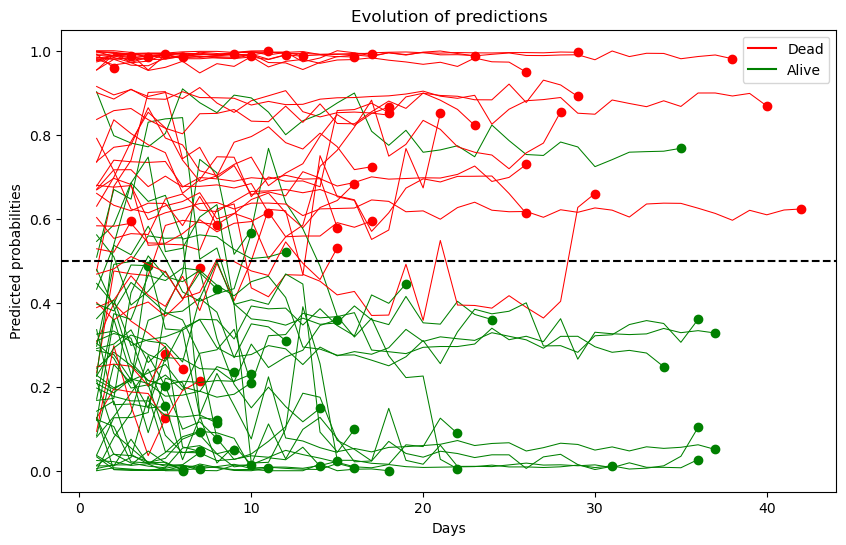

In [181]:
print_all_probability_function(X_test, prob_pred, y_test)
# This is the plot of the evolution of the probabilities for every single patient (in red the dead ones)

## Models - Logistic regression

In [182]:
numeric_features = X_train[selected].select_dtypes(include=['int', 'float']).columns
categorical_features = X_train[selected].select_dtypes(include=['bool', 'object']).columns

In [183]:
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', LogisticRegression(random_state = 2024, penalty = 'elasticnet', solver = 'saga'))
])
# We perform a standardization of the numerical features because the magnitude of the different variables are different

In [184]:
param_grid = {
    'clf__l1_ratio': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
    'clf__C': [0.001, 0.01, 0.1, 1],
}

In [185]:
grid_search = GridSearchCV(pipeline, param_grid, cv = group_kfold, scoring = 'roc_auc')
grid_search.fit(X_train[selected], y_train, groups = groups)
# With the GridSearchCV function we extract the best hyperparameters for our model (in terms of AUC in the ROC curve)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temperature', 'PEEP', 'Urine_output',
       'Hemog...
       'Superinfection pneumonia', 'Patient_category_Non-Pneumonia Control',
       'COVID_status', 'Antibiotics for other indication',
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                                       ('clf',
                                        LogisticRegression(penalty='elasticnet',
                                                           random_state=2024,
                                                           solver='saga'))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1],
                         'clf__l1_ratio': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75,
                                           0.8]},
             scoring='roc_auc')

In [186]:
best_C_lr = grid_search.best_params_['clf__C']
best_ratio_lr = grid_search.best_params_['clf__l1_ratio']
print(best_C_lr, best_ratio_lr)

0.1 0.7


In [187]:
final_model_logreg = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', LogisticRegression(random_state = 2024, penalty = 'elasticnet', solver = 'saga', C = best_C_lr, l1_ratio = best_ratio_lr))
])

final_model_logreg.fit(X_train[selected], y_train)
# Model trained with optimal hyperparameters

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temperature', 'PEEP', 'Urine_output',
       'Hemoglobin', 'Norepinephrine_rate', 'RASS_score',
       'Cumula...
       'External_transfer_flag', 'Persistent inflammation only', 'Persistence',
       'Superinfection pneumonia', 'Patient_category_Non-Pneumonia Control',
       'COVID_status', 'Antibiotics for other indication',
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                ('clf',
                 LogisticRegression(C=0.1, l1_ratio=0.7, penalty='elasticnet',
                                    random_state=2024, solver='saga'))])

In [188]:
y_pred = final_model_logreg.predict(X_test[selected])

In [189]:
accuracy_score(y_pred, y_test)

0.8007575757575758

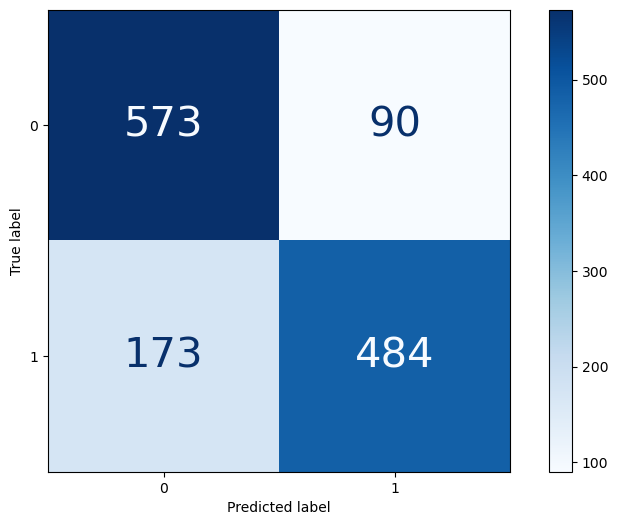

In [190]:
# The confusion matrix of the Logistic regression model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues', text_kw = {'fontsize' : 30})

In [191]:
prob_pred = final_model_logreg.predict_proba(X_test[selected])[:,1]

In [192]:
error_with_prob(prob_pred, y_test, X_test)

0.14658469977733254

In [193]:
y_test_single_outcome = y_test[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]
y_pred_single_outcome = y_pred[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]

In [194]:
accuracy_score(y_pred_single_outcome, y_test_single_outcome)

0.8536585365853658

In [195]:
fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)

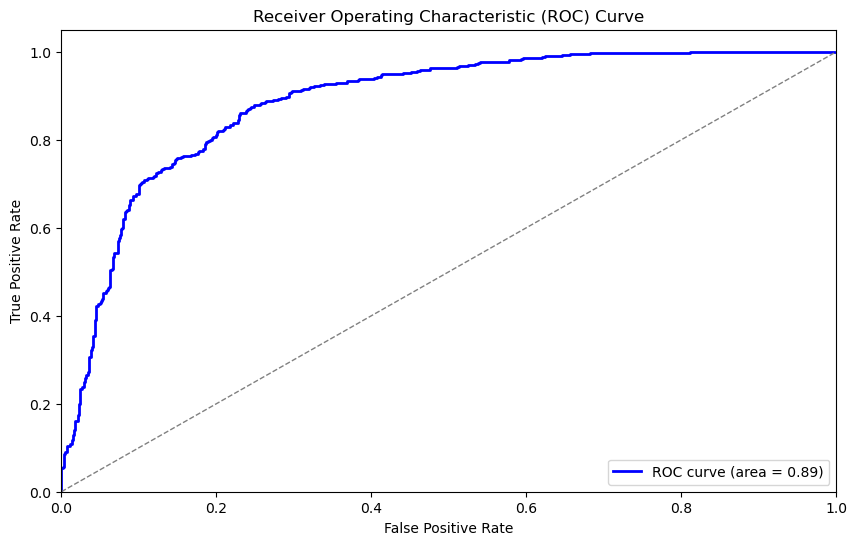

In [196]:
plt.plot(fpr, tpr, color = 'blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'gray', lw=1, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [197]:
def print_all_probability_function(X_test, prob_pred, y_test, save = False):
    id = X_test['Patient_id'].unique()
    for i in id :
        ind = X_test[X_test['Patient_id'] == i].index
        col = 'red' if np.sum(y_test[ind]) != 0 else 'green'
        plt.plot(np.arange(1, len(ind) + 1), prob_pred[ind], color = col, linewidth = 0.75)
        plt.scatter(len(ind), prob_pred[ind][-1], color = col)
    plt.axhline(y = 0.5, color = 'black', linestyle = '--')
    plt.xlabel('Days')
    plt.ylabel('Predicted probabilities')
    plt.title('Evolution of predictions')
    legend_handles = [plt.Line2D([], [], color = 'red', label = 'Dead'),
                      plt.Line2D([], [], color = 'green', label = 'Alive')
                     ]
    plt.legend(handles = legend_handles, loc = "best")
    if save == True :
        plt.savefig('prob_log.png')
    plt.show()

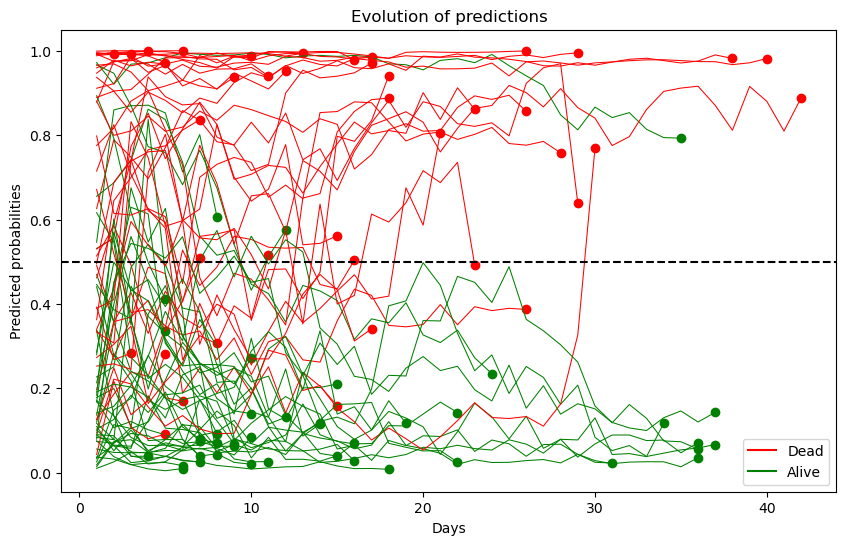

In [198]:
print_all_probability_function(X_test, prob_pred, y_test)


## Models - Support Vector Classifier

In [199]:
numeric_features = X_train[selected].select_dtypes(include=['int', 'float']).columns
categorical_features = X_train[selected].select_dtypes(include=['bool', 'object']).columns

In [200]:
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', SVC(probability = True, random_state=2024))
])

In [201]:
param_grid = [
  {'clf__kernel': ['linear'],'clf__C': [1, 10, 100], },
  {'clf__kernel': ['rbf'],'clf__C': [0.5, 1, 5, 10], 'clf__gamma': [0.05, 0.01, 0.001], },
  {'clf__kernel': ['sigmoid'],'clf__C': [10, 50, 100], 'clf__gamma': [0.05, 0.001, 0.001], }
 ]

In [202]:
grid_search = GridSearchCV(pipeline, param_grid, cv = group_kfold, scoring = 'roc_auc')
grid_search.fit(X_train[selected], y_train, groups = groups)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temperature', 'PEEP', 'Urine_output',
       'Hemog...
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                                       ('clf',
                                        SVC(probability=True,
                                            random_state=2024))]),
             param_grid=[{'clf__C': [1, 10, 100], 'clf__kernel': ['linear']},
                         {'clf__C': [0.5, 1, 5, 10],
                          'clf__gamma': [0.05, 0.01, 0.001],
                          'clf__kernel': ['rbf']},
                         {'clf__C': [10, 50, 100],
                          'clf__gamma': [0.05, 0.001, 0.001],
                          'clf__kernel': ['sigmoid']}],
             scoring='roc_auc')

In [203]:
results = grid_search.cv_results_
results = pd.DataFrame({'Score' : results['mean_test_score'], 'Params' : results['params']}).sort_values(by = 'Score', ascending = False)

In [204]:
helper = pd.DataFrame(pd.json_normalize(results['Params']).reset_index(drop = True))

In [205]:
results = results.drop(columns = 'Params').reset_index(drop = True)

In [206]:
tab = pd.concat([results, helper], axis=1)
tab
# These are all the combinations of our hyperparameters evaluated by cross-validation

,Score,clf__C,clf__gamma,clf__kernel
0,0.935756,10.0,0.001,rbf
1,0.933266,50.0,0.001,sigmoid
2,0.933266,50.0,0.001,sigmoid
3,0.933264,1.0,0.010,rbf
4,0.932198,100.0,0.001,sigmoid
5,0.932198,100.0,0.001,sigmoid
6,0.931921,5.0,0.001,rbf
7,0.930042,1.0,NaN,linear
8,0.930016,10.0,0.001,sigmoid
9,0.930016,10.0,0.001,sigmoid


In [207]:
best_kernel_svc = tab.iloc[0,3]
best_C_svc = tab.iloc[0,1]
best_gamma_svc = tab.iloc[0,2]

In [208]:
final_model_SVC = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', SVC(C = best_C_svc, kernel = best_kernel_svc, gamma = best_gamma_svc, random_state = 2024, probability = True))
])

final_model_SVC.fit(X_train[selected], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temperature', 'PEEP', 'Urine_output',
       'Hemoglobin', 'Norepinephrine_rate', 'RASS_score',
       'Cumula...
       'Admission_source_name_From Home/Work', 'Recurrence',
       'External_transfer_flag', 'Persistent inflammation only', 'Persistence',
       'Superinfection pneumonia', 'Patient_category_Non-Pneumonia Control',
       'COVID_status', 'Antibiotics for other indication',
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                ('clf',
                 SVC(C=10.0, gamma=0.001, probability=True,
                     random_state=2024))])

In [209]:
y_pred = final_model_SVC.predict(X_test[selected])

In [210]:
accuracy_score(y_pred, y_test)

0.7909090909090909

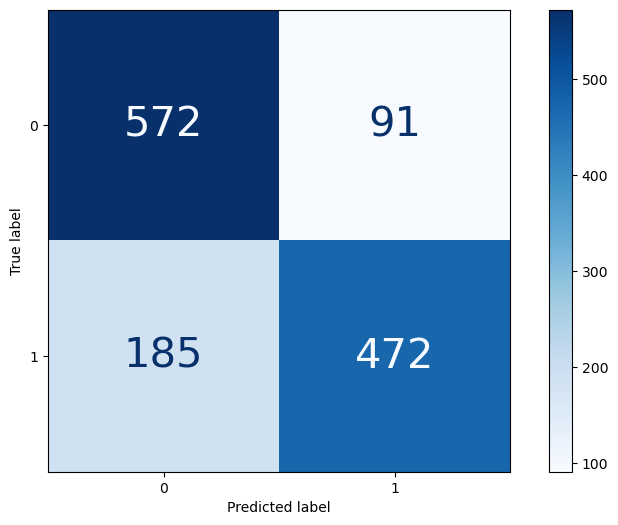

In [211]:
cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues',text_kw = {'fontsize' : 30})

In [212]:
prob_pred = final_model_SVC.predict_proba(X_test[selected])[:,1]

In [213]:
error_with_prob(prob_pred, y_test, X_test)

0.15405063216637105

In [214]:
y_test_single_outcome = y_test[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]
y_pred_single_outcome = y_pred[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]

In [215]:
accuracy_score(y_pred_single_outcome, y_test_single_outcome)

0.8902439024390244

In [216]:
fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)

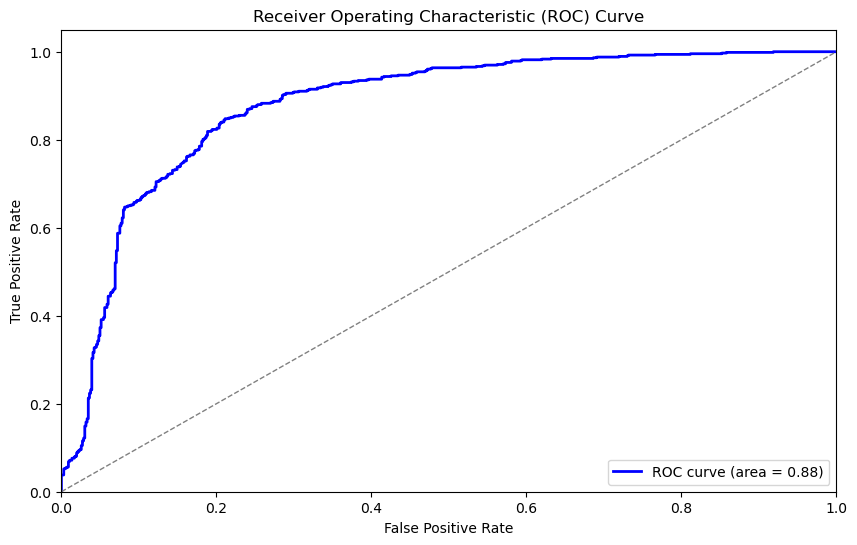

In [217]:
plt.plot(fpr, tpr, color = 'blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'gray', lw=1, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = "lower right")
plt.show()

In [218]:
def print_all_probability_function(X_test, prob_pred, y_test, save = False):
    id = X_test['Patient_id'].unique()
    for i in id :
        ind = X_test[X_test['Patient_id'] == i].index
        col = 'red' if np.sum(y_test[ind]) != 0 else 'green'
        plt.plot(np.arange(1, len(ind) + 1), prob_pred[ind], color = col, linewidth = 0.75)
        plt.scatter(len(ind), prob_pred[ind][-1], color = col)
    plt.axhline(y = 0.5, color = 'black', linestyle = '--')
    plt.xlabel('Days')
    plt.ylabel('Predicted probabilities')
    plt.title('Evolution of predictions')
    legend_handles = [plt.Line2D([], [], color = 'red', label = 'Dead'),
                      plt.Line2D([], [], color = 'green', label = 'Alive')
                     ]
    plt.legend(handles = legend_handles, loc = "best")
    if save == True :
        plt.savefig('prob_svc.png')
    plt.show()

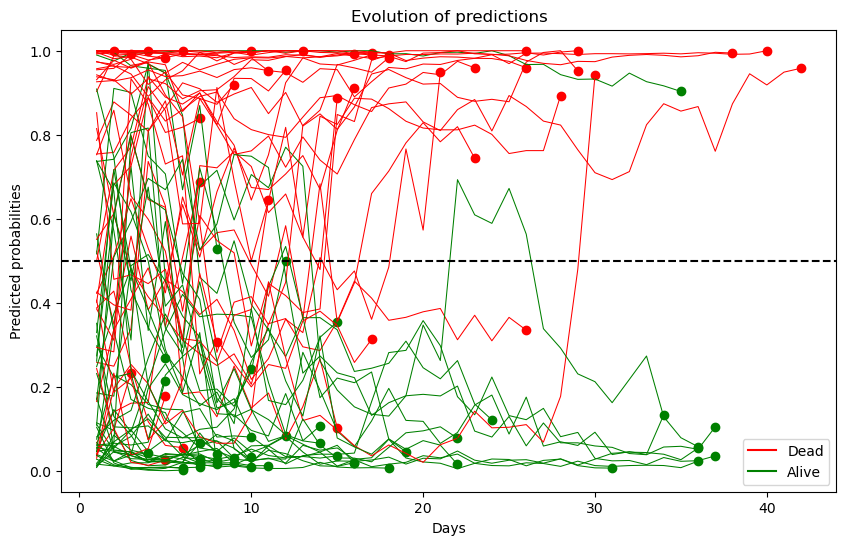

In [219]:
print_all_probability_function(X_test, prob_pred, y_test)

## Models - Voting Classifier

In [220]:
numeric_features = X_train[selected].select_dtypes(include=['int', 'float']).columns
categorical_features = X_train[selected].select_dtypes(include=['bool', 'object']).columns

In [221]:
lr = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', LogisticRegression(random_state = 2024, penalty = 'elasticnet', solver = 'saga', C = best_C_lr, l1_ratio = best_ratio_lr))
])

rf = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 3, oob_score = True, random_state = 2024, max_features = 0.5)

svc = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', SVC(C = best_C_svc, kernel = best_kernel_svc, gamma = best_gamma_svc, random_state = 2024, probability = True))
])
# In the voting classifier, we employ the three models used before with the already computed hyperparameters

In [222]:
voting_clf = VotingClassifier(estimators = [('lr', lr), ('rf', rf), ('svc', svc)])

In [223]:
type_of_voting = {
    'voting': ['hard', 'soft'],
}

In [224]:
random.seed(2024)
grid_search = GridSearchCV(voting_clf, type_of_voting, cv = group_kfold, scoring = 'roc_auc')
grid_search.fit(X_train[selected], y_train, groups = groups)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(steps=[('preprocessor',
                                                                      ColumnTransformer(transformers=[('numeric',
                                                                                                       StandardScaler(),
                                                                                                       Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temper...
       'External_transfer_flag', 'Persistent inflammation only', 'Persistence',
       'Superinfection pneumonia', 'Patient_category_Non-Pneumonia Control',
       'COVID_status', 'Antibiotics for other indication',
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                                                                     ('clf',
                                                                      SVC(C=10.0,
                                                                          gamma=0.001,
                                                                          probability=True,
                                                                          random_state=2024))]))]),
             param_grid={'voting': ['hard', 'soft']}, scoring='roc_auc')

In [225]:
best_voting = grid_search.best_params_['voting']
best_voting

'soft'

In [226]:
final_voting_clf = VotingClassifier(estimators = [('lr', lr), ('rf', rf), ('svc', svc)], voting = best_voting)
final_voting_clf.fit(X_train[selected], y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                StandardScaler(),
                                                                                Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temperature', 'PEEP', 'Urine_output',
       'Hemoglobin', 'Norepi...
       'External_transfer_flag', 'Persistent inflammation only', 'Persistence',
       'Superinfection pneumonia', 'Patient_category_Non-Pneumonia Control',
       'COVID_status', 'Antibiotics for other indication',
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                                              ('clf',
                                               SVC(C=10.0, gamma=0.001,
                                                   probability=True,
                                                   random_state=2024))]))],
                 voting='soft')

In [227]:
y_pred = final_voting_clf.predict(X_test[selected])

In [228]:
accuracy_score(y_pred, y_test)

0.8257575757575758

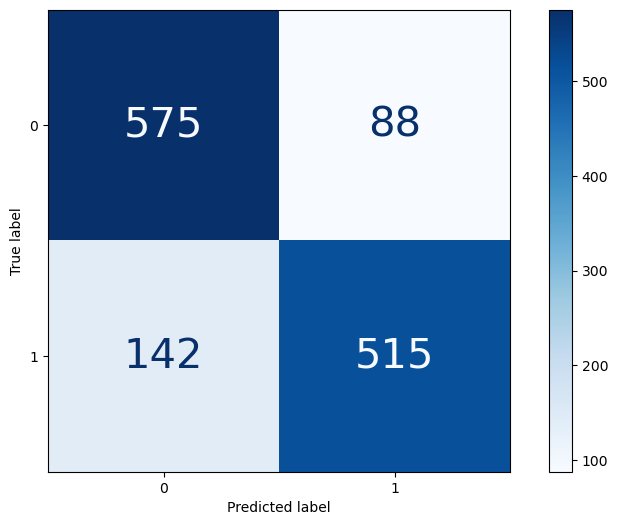

In [229]:
cm =confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues',text_kw = {'fontsize' : 30})

In [230]:
prob_pred = final_voting_clf.predict_proba(X_test[selected])[:,1]

In [231]:
error_with_prob(prob_pred, y_test, X_test)

0.12837378520824239

In [232]:
y_test_single_outcome = y_test[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]
y_pred_single_outcome = y_pred[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]

In [233]:
accuracy_score(y_pred_single_outcome, y_test_single_outcome)

0.8536585365853658

In [234]:
fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)

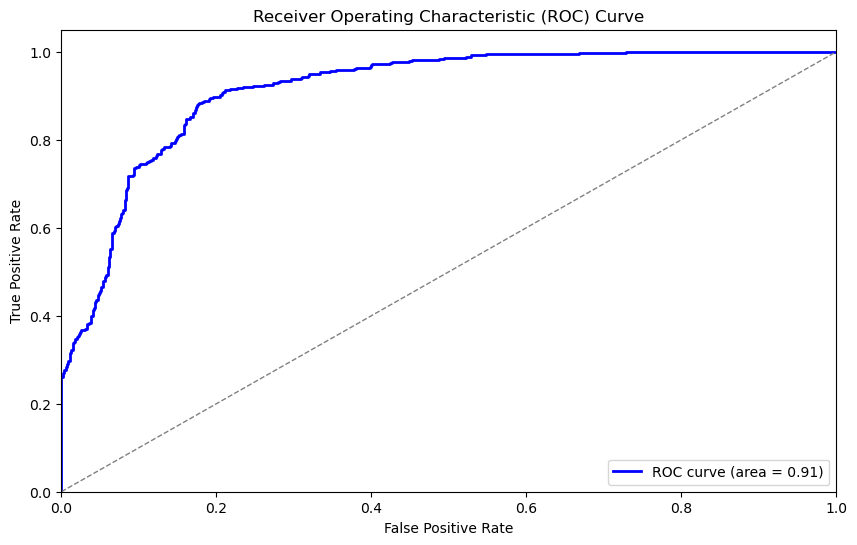

In [235]:
plt.plot(fpr, tpr, color = 'blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'gray', lw=1, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = "lower right")
plt.show()

In [236]:
def print_all_probability_function(X_test, prob_pred, y_test, save = False):
    id = X_test['Patient_id'].unique()
    for i in id :
        ind = X_test[X_test['Patient_id'] == i].index
        col = 'red' if np.sum(y_test[ind]) != 0 else 'green'
        plt.plot(np.arange(1, len(ind) + 1), prob_pred[ind], color = col, linewidth = 0.75)
        plt.scatter(len(ind), prob_pred[ind][-1], color = col)
    plt.axhline(y = 0.5, color = 'black', linestyle = '--')
    plt.xlabel('Days')
    plt.ylabel('Predicted probabilities')
    plt.title('Evolution of predictions')
    legend_handles = [plt.Line2D([], [], color = 'red', label = 'Dead'),
                      plt.Line2D([], [], color = 'green', label = 'Alive')
                     ]
    plt.legend(handles = legend_handles, loc = "best")
    if save == True :
        plt.savefig('prob_voting.png')
    plt.show()

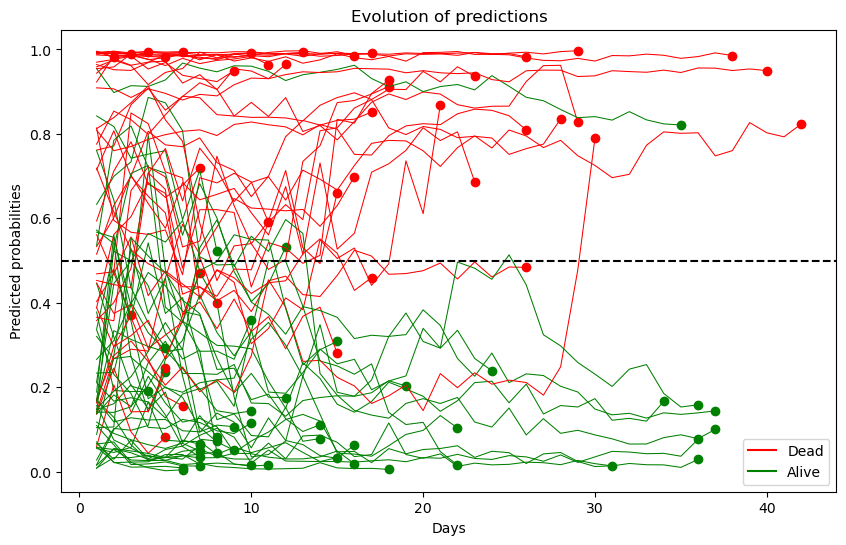

In [237]:
print_all_probability_function(X_test, prob_pred, y_test)

## Models - KNN classifier

In [238]:
numeric_features = X_train[selected].select_dtypes(include=['int', 'float']).columns
categorical_features = X_train[selected].select_dtypes(include=['bool', 'object']).columns

In [239]:
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', MinMaxScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', KNeighborsClassifier(algorithm = 'ball_tree'))
])
# This time we use the MaxMinScaler for numerical variables in order to have an appropriate estimation of the distances
# The algorith 'ball_tree' manage datasets with high dimensionality keeping good performance

In [240]:
param_grid = {
    'clf__n_neighbors': [50, 60, 70, 75, 80, 90, 100, 150],
    'clf__metric': ['l1', 'l2'],
}

In [241]:
grid_search = GridSearchCV(pipeline, param_grid, cv = group_kfold, scoring = 'roc_auc')
grid_search.fit(X_train[selected], y_train, groups = groups)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         MinMaxScaler(),
                                                                         Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temperature', 'PEEP', 'Urine_output',
       'Hemoglo...
       'Superinfection pneumonia', 'Patient_category_Non-Pneumonia Control',
       'COVID_status', 'Antibiotics for other indication',
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                                       ('clf',
                                        KNeighborsClassifier(algorithm='ball_tree'))]),
             param_grid={'clf__metric': ['l1', 'l2'],
                         'clf__n_neighbors': [50, 60, 70, 75, 80, 90, 100,
                                              150]},
             scoring='roc_auc')

In [242]:
results = grid_search.cv_results_
results = pd.DataFrame({'Score' : results['mean_test_score'], 'Params' : results['params']}).sort_values(by = 'Score', ascending = False)

In [243]:
helper = pd.DataFrame(pd.json_normalize(results['Params']).reset_index(drop = True))

In [244]:
results = results.drop(columns = 'Params').reset_index(drop = True)

In [245]:
tab = pd.concat([results, helper], axis=1)
tab

,Score,clf__metric,clf__n_neighbors
0,0.889177,l1,60
1,0.888917,l1,50
2,0.888344,l1,70
3,0.887273,l1,75
4,0.886788,l1,80
5,0.885587,l1,90
6,0.885299,l2,70
7,0.885206,l2,75
8,0.885009,l1,100
9,0.884952,l2,60


In [246]:
best_n_neigh = tab.iloc[0,2]
best_metric = tab.iloc[0,1]

In [247]:
final_model_knn = Pipeline([
    ('preprocessor', ColumnTransformer(transformers = [
        ('numeric', MinMaxScaler(), numeric_features),
        ('categorical', 'passthrough', categorical_features)
    ])),
    ('clf', KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors = best_n_neigh, metric = best_metric))
])

final_model_knn.fit(X_train[selected], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  Index(['Number_of_ICU_stays', 'Episode_duration', 'Diastolic_blood_pressure',
       'Mean_arterial_pressure', 'GCS_eye_opening', 'Lung_Compliance',
       'Plateau_Pressure', 'WBC_count', 'Temperature', 'PEEP', 'Urine_output',
       'Hemoglobin', 'Norepinephrine_rate', 'RASS_score',
       'Cumulati...
       'External_transfer_flag', 'Persistent inflammation only', 'Persistence',
       'Superinfection pneumonia', 'Patient_category_Non-Pneumonia Control',
       'COVID_status', 'Antibiotics for other indication',
       'Race_Black or African American', 'Tracheostomy_flag',
       'Smoking_status_Never Smoker'],
      dtype='object'))])),
                ('clf',
                 KNeighborsClassifier(algorithm='ball_tree', metric='l1',
                                      n_neighbors=60))])

In [248]:
y_pred = final_model_knn.predict(X_test[selected])

In [249]:
accuracy_score(y_pred, y_test)

0.7143939393939394

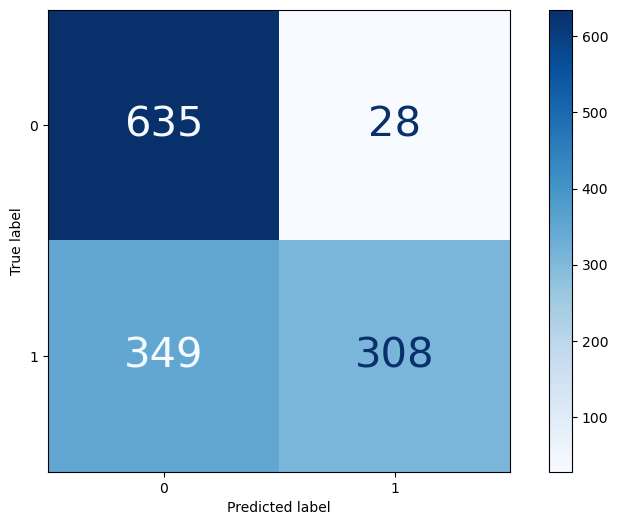

In [250]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues',text_kw = {'fontsize' : 30})

In [251]:
prob_pred = final_model_knn.predict_proba(X_test[selected])[:,1]

In [252]:
error_with_prob(prob_pred, y_test, X_test)

0.1889464913110635

In [253]:
y_test_single_outcome = y_test[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]
y_pred_single_outcome = y_pred[X_test.drop_duplicates(subset = ['Patient_id'], keep = 'last').index]

In [254]:
accuracy_score(y_pred_single_outcome, y_test_single_outcome)

0.7560975609756098

In [255]:
fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)

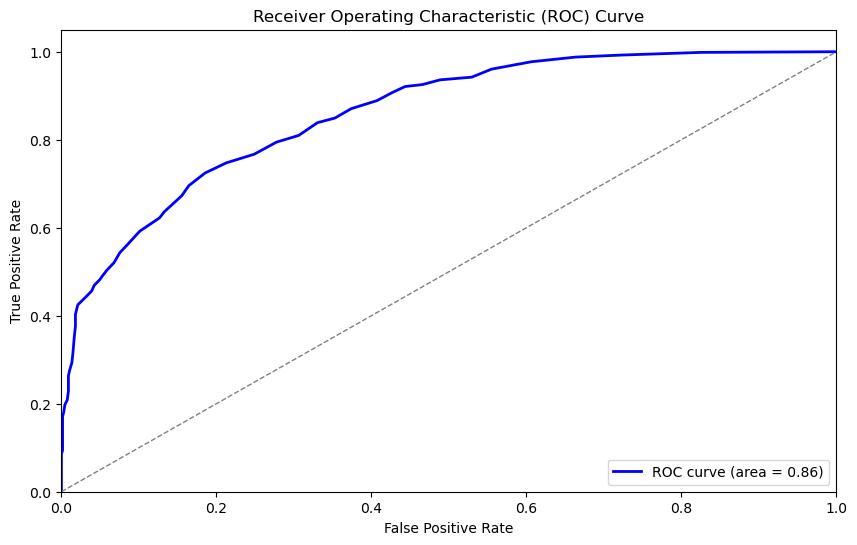

In [256]:
plt.plot(fpr, tpr, color = 'blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'gray', lw = 1, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

In [257]:
def print_all_probability_function(X_test, prob_pred, y_test, save = False):
    id = X_test['Patient_id'].unique()
    for i in id :
        ind = X_test[X_test['Patient_id'] == i].index
        col = 'red' if np.sum(y_test[ind]) != 0 else 'green'
        plt.plot(np.arange(1, len(ind) + 1), prob_pred[ind], color = col, linewidth = 0.75)
        plt.scatter(len(ind), prob_pred[ind][-1], color = col)
    plt.axhline(y = 0.5, color = 'black', linestyle = '--')
    plt.xlabel('Days')
    plt.ylabel('Predicted probabilities')
    plt.title('Evolution of predictions')
    legend_handles = [plt.Line2D([], [], color = 'red', label = 'Dead'),
                      plt.Line2D([], [], color = 'green', label = 'Alive')
                     ]
    plt.legend(handles = legend_handles, loc = "best")
    if save == True :
        plt.savefig('prob_knn.png')
    plt.show()

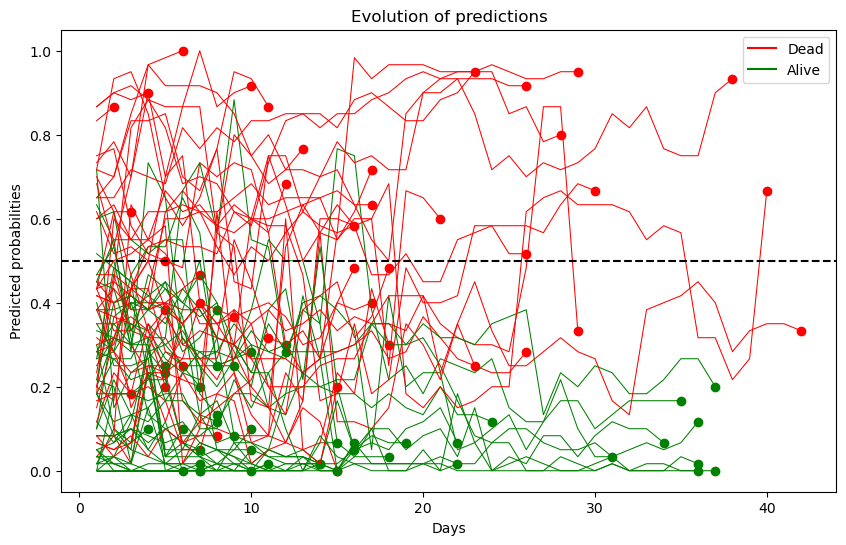

In [258]:
print_all_probability_function(X_test, prob_pred, y_test)

## Feature contribution

We inspect the impact of the variables in the case of the Random Forest (our best model for prediction) employing its built-in function 'feature_importance'

In [259]:
pd.Series(random_forest.feature_importances_, index = random_forest.feature_names_in_).sort_values(ascending = False)

Persistent inflammation only                          0.302964
SOFA_score                                            0.076067
Superinfection pneumonia                              0.073884
Age                                                   0.055465
Admit_APS_score                                       0.050171
Cumulative_ICU_days                                   0.045781
Cumulative_intubation_days                            0.045495
Persistence                                           0.032253
Diastolic_blood_pressure                              0.032239
Patient_category_Non-Pneumonia Control                0.030375
Number_of_ICU_stays                                   0.027065
Hemoglobin                                            0.017777
WBC_count                                             0.017688
Temperature                                           0.015933
CRRT_flag                                             0.015768
Race_Black or African American                        0

In [260]:
pd.crosstab(X_train['Persistent inflammation only'], y_train)

Binary_outcome,False,True
Persistent inflammation only,,
False,2612,1284
True,12,1302


In [261]:
pd.crosstab(X_train['Superinfection pneumonia'], y_train)

Binary_outcome,False,True
Superinfection pneumonia,,
False,2582,2203
True,42,383


From the two tables we can see a huge impact on the target, especially in the first case. So it is perfectly reasonable to have these two variables in the first positions of the ranking.